<h1 align = 'center'>Computer Vision Final Project: Breast Cancer Tumor Classification</h1>
<h2 align = 'center'>Section 1 Spring 2023</h2>
<h3 align = 'center'> Nicholas Lee, Nic Brathwaite, Amir Moayed</h3>

<h4 align = 'center'><a href = "https://github.com/NickBrath/Computer-Vision-281-Final-Project">Github Repository</a></h4>

<p align = 'center'><a href="https://colab.research.google.com/github/NickBrath/Computer-Vision-281-Final-Project/blob/main/Nick_Lee_Baseline_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a></p>

# Introduction
Breast cancer is the most prevalent form of cancer, accounting for 2,261,419 (11.7%) of the 19,292,789 cases reported worldwide in 2020 according to the world health organization. Early diagnosis of cancer is crucial in ensuring the best chances of recovery. One main method is biopsing tissue for tumor detection using immunohistochemistry staining. Staining tissues is labor and time intensive, and training an expert to interpret the results takes even longer. Even experts have bias in their analysis so a lot of research has been geared towards using machine learning and computer vision to help detect cancer faster and at scale. The purpose of this project is to create a tool to help experts classify breast tumors as either benign or malignant (cancerous) subtypes from histopathological images.  

<u>Data</u>  
The Breast Cancer Histopathological Image Classification (BreakHis) is composed of 9,109 microscopic images of breast tumor tissue collected from 82 patients using different magnifying factors (40X, 100X, 200X, and 400X).  The dataset contains 2,480 benign and 5,429 malignant samples (700X460 pixels, 3-channel RGB, 8-bit depth in each channel, PNG format). In total there are two major classes of identification: benign and malignant. Furthermore, there are eight sub categories of classification, 4 in each of the main categories. 


<center><img src="..\imgs\tumor_classification_tree.png" alt="map of tumor classification" height = 400 width = 600/></center>

Possible features of benign tumors to look for in images: 
histologically benign [1]
	(adjective) Referring to a lesion that does not meet any criteria of malignancy – e.g., marked cellular atypia, mitosis, disruption of basement membranes, metastasize.



---

**Remove before submission**

Consuming TFRecord data
Refer to the Loading TFRecords tutorial for an end-to-end example.

The tf.data API supports a variety of file formats so that you can process large datasets that do not fit in memory. For example, the TFRecord file format is a simple record-oriented binary format that many TensorFlow applications use for training data. The tf.data.TFRecordDataset class enables you to stream over the contents of one or more TFRecord files as part of an input pipeline.

*look at transfer learning for other similar problems that might help our model https://www.tensorflow.org/guide/keras/transfer_learning*

---

# Setup

## Packages

In [170]:
# Google packages
# from google.colab import drive
# from google.colab import files
# from google.colab.patches import cv2_imshow

# Mount google drive
# drive.mount('/content/drive')

In [171]:
# high resolution images
%config InlineBackend.figure_format ='retina'

In [172]:
# base packages
import os
import warnings
import datetime
from datetime import date
import shutil

from tqdm.notebook import tqdm  # progress bar library
# import glob
# import re
# import random

# DS packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

%matplotlib inline

# image packages
import PIL
from PIL import Image, ImageStat
import urllib
import cv2
from skimage.color import rgb2gray
import skimage.io as skio
import tabulate

# ML packages
import scipy as sc
import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint

# from keras.layers.core import Dense, Dropout, Flatten
# from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D

# import tensorflow_addons as tfa

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report

import tomopy
import mkl
# Intel(R) MKL FFT functions to run sequentially
mkl.domain_set_num_threads(1, domain='fft')


# options
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")

og_cmap = plt.get_cmap(name=None, lut=None)
AUTOTUNE = tf.data.AUTOTUNE

seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype("int32")

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [173]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.config.list_physical_devices('GPU')

## Functions

### Loading data

In [174]:
# pickle object for later
import pickle

def pickler(ob, pklFileName):
    """ 
      Create pickle object to load later or in different environments for use later

      ob: object, python object intended to pickle
      pklFileName: string, name of the pickle file e.g. "User/content/drive/209/ThisDataFrame.pkl"
    """

    with open(pklFileName, "wb+") as f:
        pickle.dump(ob, f)


def load_pickles(pklFilePath):
    """
      path: string, path to object
      pklFileName: string, pickle file name with extension .pkl
    """

    return pd.read_pickle(pklFilePath)


In [175]:
def imshow(image, title=None):
  """ Show image from tensor"""
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    
def clip_0_1(image):
  """ Ensure values for image are between 0 and 1"""
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [176]:
def create_image_set(ds, num_images = 5): 
    """ Create preview of images with labels 
    Takes the num_images from the dataset for viewing in plots
    
    Args: 
    ds (tensorflow dataset): tensorflow dataset with images
    """
    
    images = []
    for i, t in enumerate(ds.take(num_images)): 
        images.append(
            {'label': tf.argmax(t[1].numpy()).numpy(), 
            'im' : t[0].numpy()}
        )

    return images

In [177]:
def create_image_set_batched(ds, batch_size = 32, num_images = 1): 
    """ Create preview of images with labels 
    Takes the num_images from the dataset for viewing in plots. meant to work with batched data
    
    Args: 
    ds (tensorflow dataset): tensorflow dataset with images
    """
    
    images = []
    for i, t in enumerate(ds.take(num_images)):
        test_labels = tf.argmax(t[1], axis = 1).numpy()
        for b in range(batch_size):
            images.append(
                {'label': test_labels[b], 
                'im' : t[i][b].numpy()}
            )
    return images

### EDA functions

In [178]:
def load_im_get_stats(file, path): 
    results = pd.DataFrame()
    
    im = Image.open(path)
    stats = ImageStat.Stat(im)
    
    # get stats for image
    for band,channel in enumerate(im.getbands()): 
        # print(f'Band: {name}, min/max: {stats.extrema[band]}, stddesv: {stats.stddev[band]}')
        temp = {
            'BASE_NAME':file,
            'channel': channel,
            'Min' : [stats.extrema[band][0]],
            'Max' : [stats.extrema[band][1]],
            'stddev' : [stats.stddev[band]]
        }

        results = pd.concat([results, pd.DataFrame.from_dict(temp)])
        
        del temp
    
    return results

### Plotting Functions

In [179]:
# all the functions used for viewing images and model results
# %run ../python/plotting_functions.py

In [180]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total Malignant Cases: ', np.sum(cm[1]))

In [181]:
def plot_images(images, nrows, ncols, gray_scale = False): 
    """ List of image dictionaries with label: value, im: array"""

    if gray_scale == True: 
        plt.set_cmap("gray")
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(8, 3))    
    fig.text(.5, .0001, "Sample of images from dataset", ha='center')

    if nrows == 1 or ncols == 1:
        plots = max(nrows, ncols)
        for i in range(plots):
            label = str(images[i]['label'])
            
            im = images[i]['im']

            # add image to axes
            axs[i].imshow(im)
            # drop axis labels
            axs[i].axis('off')
            # add axes title
            axs[i].set(title=label)
            
    else: 
        # create iterator to continuously index the images
        im_index = 0
        for r in range(nrows):
            for c in range(ncols):
                # label for subplot title
                label = str(images[im_index]['label'])
                
                # image array
                im = images[im_index]['im']

                # add image to axes
                axs[r,c].imshow(im)
                
                # drop axis labels
                axs[r,c].axis('off')
                
                # add axes title
                axs[r,c].set(title=label)
                
                # next index
                im_index += 1
                
    plt.tight_layout()
    plt.show();

In [182]:
def plot_images_with_histogram(images, nrows): 
    """ List of image dictionaries with label: value, im: array
    plots image with histogram side by side
    """
    
    fig, axs = plt.subplots(nrows, ncols = 2,  figsize=(20, 20), layout="constrained")

    # Flatten axes to make it easier to access
    # axs = axs.flatten()

    for i, im in enumerate(images):
        #read in file
        # pic = plt.imread(file)
        label = str(im['label'])
        
        im = im['im']
        # add image to axes
        axs[i, 0].imshow(im)
        # drop axis labels
        axs[i, 0].axis('off')
        # add axes title
        axs[i, 0].set(title=label)
        
        # add histogram 
        axs[i, 1].hist((im*255).ravel(), bins = 100, fc='k', ec='k')
        
    fig.tight_layout()
    
    plt.show()

### Dataset Creation for Models

In [251]:
def create_one_hot_encoding(file_paths, labels): 
    """convert labels to numeric representation"""
    
    # create encoder
    labelencoder = LabelEncoder()
    
    depth = len(set(labels))

    # apply encoder to change string labels to integer
    labels_encoded = labelencoder.fit_transform(labels)

    # One-hot encodning to feed into model(s)
    labels = tf.one_hot(labels_encoded, depth=depth)

    # create dataset (ds)
    ds = create_tf_ds(file_paths, labels)
    
    return ds, labelencoder

In [185]:
def decoder(ds): 
    # get labels out of tf set
    y = np.concatenate([y for x, y in ds], axis=0) # works since ds is batched
    # labels = labelencoder.inverse_transform(y.argmax(axis = 1))
    labels = y.argmax(axis = 1)
    return labels

In [187]:
def read_image_binary(image_file_path, label): 
    """Function to read in images to create tf dataset. Adds an extra dimension for batch. Allows use on sobel filter. """
    
    image = tf.io.read_file(image_file_path)  # read in image
    
    # preserving RGB colors with channels = 3. Reads array
    image = tf.image.decode_image(image, channels=3, dtype=tf.float64)
    
    # add batch dimension
    image = image[tf.newaxis, :]

    return image, label

In [188]:
def create_tf_ds(file_paths, labels):
    """ Create tensorflow dataset from file paths and labels """
    # create dataset
    ds = tf.data.Dataset.from_tensor_slices(
        (file_paths, labels))  # mapping like a zip in python

    return ds

def read_image(image_file_path, label):
    """Function to read in images to create tf dataset"""
    
    image = tf.io.read_file(image_file_path)  # read in image
    
    # preserving RGB colors with channels = 3. Reads array
    image = tf.image.decode_image(image, channels=3, dtype=tf.float64) 

    return image, label

In [189]:
def split_ds_tvt(ds, read_image_fn  = read_image, train_size = 0.7, val_size = 0.1, test_size = 0.2): 
    """ Train test split dataset. Read images into tensor dataset.
    
    Args: 
    train_size, val_size, test_size (float): sum to 1
    
    """
    DATASET_SIZE = ds.cardinality().numpy()

    train_size = int(train_size * DATASET_SIZE)
    val_size = int(val_size * DATASET_SIZE)
    test_size = int(test_size * DATASET_SIZE)

    ds = ds.shuffle(buffer_size= DATASET_SIZE)
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    val_ds = test_ds.skip(val_size)
    test_ds = test_ds.take(test_size)

    print(tf.data.experimental.cardinality(train_ds).numpy())
    print(tf.data.experimental.cardinality(val_ds).numpy())
    print(tf.data.experimental.cardinality(test_ds).numpy())
    
    # train_ds = train_ds.map(read_image)
    # val_ds = val_ds.map(read_image)
    # test_ds = test_ds.map(read_image)
    
    return train_ds, val_ds, test_ds

In [190]:
def optimize_tensor(ds): 
    ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
    return ds

### Augmentation Functions

Rubric: 
At least 2 simple feature types
1. [ ] HOG
2. [ ] local binary pattern

- [] Image Sharpening
- [] Contrast
- [] GrayScale

One complex feature: 
1. [ ] Parameter Free Threshold Adjacency Statistics (PFTAS)

- [x] Edge Detection : applied sobel edge detection
- [] Feature Tracking

tf functions for images: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image

https://www.tensorflow.org/api_docs/python/tf/image/extract_patches

#### Basic Augmentations

In [191]:
def augment_crop(image, label, height = 450, width = 700): 
    """ Crops image by defining a bounding box
    
    Using to make sure the images are the same size.     
    """
    # normalize image size to a square and get smaller subsection
    image = tf.image.random_crop(value=image, size=(height, width, 3))
    
    return image, label

In [192]:
def augment_centralcrop(image, label): 
    """take image and return fraction of the image cropped centered"""
    # needs work
    image = tf.image.central_crop(image, 0.5)
    
    return image, label

In [193]:
def augment_patches(image, label): 
    """ Get patches of image like a convolution"""
    #### Random sample 32, 32, 3 like they do in the paper
    
    image = tf.image.extract_patches(
        images=image,
        sizes=[1, 32, 32, 1],
        strides=[1, 16, 16, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
        )
    
    return image, label

In [194]:
def augment_grayscale(image, label):
    # turn image from RGB to grayscale
    image = tf.image.rgb_to_grayscale(image)
    
    # if tf.random.uniform((), minval=0, maxval=1) < 0.1:
    #     image = tf.tile(tf.image(tf.image.rgb_to_grayscale(image), [1, 1, 3]))
    
    return image, label

In [195]:
def augment_sharpen(image, label): 
    
    # image sharpening
    
    return image, label

In [196]:
def augment_contrast(image, label): 
    """ Adjust contrast of image """
    
    image = tf.image.random_contrast(image, lower=0.1, upper=0.5)
    
    return image, label

In [197]:
def augment_normalize(image, label):
    """ Normalize images for pixel intensity variations to gaussian distribution"""
    
    return tf.cast(image, tf.float32) / 255.0, label

In [198]:
def augment_brightness(image, label): 
    """ Change image brightness on pixels a random amount """
    image = tf.image.random_brightness(image, max_delta=0.1)
    
    return image, label

In [199]:
def augment_flip(image,label):
    """ horizontal and vertically flip images"""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    return image, label

In [200]:
def augment_rotation(image, label): 
    """ Apply a random rotation """
    
    image = tf.keras.preprocessing.image.random_rotation(image)
    
    return image, label

In [201]:
def augment_resize(image, label): 
    """ standardize image size"""
    image = tf.image.resize(image, size = [128, 128])

### Advanced Augmentations

In [202]:
def read_image_sobel(image_file_path, label):
    """Function to read in images to create tf dataset. Adds an extra dimension for batch. Allows use on sobel filter. """
    
    image = tf.io.read_file(image_file_path)  # read in image
    
    # preserving RGB colors with channels = 3. Reads array
    image = tf.image.decode_image(image, channels=3, dtype=tf.float32)
    
    # add batch dimension
    image = image[tf.newaxis, :]

    return image, label

In [203]:
def augment_sobel_edges(image, label): 
    """ Apply the sobel-edge dector function over tensors"""
    image = tf.image.sobel_edges(image)
    
    return image, label

In [204]:
def augment(image, label):
    """ Basic augmentation, it has to at least crop the images since there are unequal sizes for the arrays"""
    
    image, label = augment_crop(image,label)
   
    return image, label

### Dataset Creation Functions

In [205]:
def read_ds(ds, read_fn = read_image, augment_fn = augment_crop): 
    """ Read in images to arrays and augment with predefined process"""
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.map(read_fn, num_parallel_calls=AUTOTUNE).map(augment_fn, num_parallel_calls=AUTOTUNE)
    return ds

In [206]:
def configure_for_performance(ds, batch_size = 32):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [207]:
def preprocess_ds(ds, read_fn = read_image, augment_fn = augment_crop):
    """ Steps to get data ready for model training and testing. 
    
    This is mean to be a way to create a dataset for use in models quickly and effectively. 
    
    Args: 
        ds (tensorflow dataset): created dataset with image, label structure
        read_fn: read image function
    
    Returns: 
        train_ds, val_ds, test_ds (tensor datasets): train, validation, and test datasets for traininga and evaluating models. 
    """
    # split
    train_ds, val_ds, test_ds = split_ds_tvt(ds)
    
    # optimize
    train_ds = optimize_tensor(train_ds)
    val_ds = optimize_tensor(val_ds)
    
    # read in and augment data
    train_ds = read_ds(train_ds, read_fn, augment_fn)
    val_ds = read_ds(val_ds, read_fn, augment_fn)
    test_ds = read_ds(test_ds, read_fn, augment_fn)
    
    return train_ds, val_ds, test_ds
    

In [208]:
def prepare_ds(ds, shuffle=False, augment=False, batch_size=32):
    """ Prepare dataset for models. Augmentation can be appliied with the flag"""

    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_rescale_layer(x), y),
                num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_aug_layer(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
        
        # ds = ds.map(lambda x, y:(histogram_equalization(x), y), num_parallel_calls = AUTOTUNE)
    
    # Batch all datasets.
    # ds = ds.batch(batch_size)
    ds = configure_for_performance(ds)
    
    return ds

### Model Functions

In [209]:
def model_checkpoint_constructor(checkpoint_name): 
    """ Define the callback to save the model weights """
    checkpoint_path = os.path.join(r"..\models\checkpoints", checkpoint_name)
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor="accuracy",
        save_best_only=True,
        verbose=1
    )
    
    return checkpoint_callback

In [210]:
def get_optimizer(learning_rate = 0.001, decay_steps = 1000, decay_rate = 1, staircase_flag = False):
  """ Learning rate schedule"""
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  learning_rate,
  decay_steps=decay_steps,
  decay_rate=decay_rate,
  staircase=staircase_flag)

  return tf.keras.optimizers.Adam(lr_schedule)

In [211]:
def load_model(model, checkpoint_path):
    """ Load model from previous work"""
    model.load_weights(checkpoint_path)
    return model

In [212]:
def compile_fit_model(model): 
    """_summary_

    Args:
        model (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy',
            tf.keras.metrics.Precision(), 
            tf.keras.metrics.TruePositives(thresholds=0),
            tf.keras.metrics.TrueNegatives(thresholds=0),
            tf.keras.metrics.FalseNegatives(thresholds=0),
            tf.keras.metrics.FalsePositives(thresholds=0)])

    hist = model.fit(
        train_ds,
        verbose = 1,
        validation_data=val_ds,
        epochs=3
    )
    
    return model, hist

In [346]:
def create_tf_board(log_name): 
    """ Create logs for tensorboard """
    
    path = f'./models/logs/{log_name}/'
    
    # if os.path.exists(path):
    #     # Clear any logs from previous runs
    #     shutil.rmtree(path)
    
    log_dir = path + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    return tensorboard_callback

In [214]:
def launch_tensorboard(log_name): 
    %tensorboard --logdir f'./models/logs/{log_name}'

In [215]:
def save_weights(model, model_name): 
    """ saving weights of the model to the models folder """
    model.save_weights(f'./models/model_weights/{model_name}/{model_name}_weights', save_format='tf')
    
def save_model(model, model_name): 
    """ Save the model for use later"""
    saved_model_path = f"/models/saved_{model_name}"
    tf.saved_model.save(model, saved_model_path)

In [216]:
def plot_hist(hist): 
    """ View into model history. 
    hist = model.fit() results
    
    """
    
    # get history
    hist_dict = hist.history
    hist_df = pd.DataFrame.from_dict(hist_dict)

    # Use index to get Epochs
    hist_df.reset_index(inplace = True)
    hist_df.rename({'index': 'Epoch'}, axis = 1, inplace = True)
    # hist_df = pd.melt(hist_df, id_vars = 'index')

    # Create Subsets
    accuracy = hist_df.loc[:, ['Epoch','accuracy', 'val_accuracy']]
    loss = hist_df.loc[:, ['Epoch', 'loss', 'val_loss']]

    # Flatten dfs
    accuracy = pd.melt(accuracy, id_vars = 'Epoch')
    loss = pd.melt(loss, id_vars = 'Epoch')

    # flatten df to plot
    # hist_melt = pd.melt(hist_df, id_vars = 'index').rename({'index': 'Epoch'}, axis = 1)

    # call regplot on each axes
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)

    sns.lineplot(data = accuracy, ax = ax1, x = 'Epoch', y = 'value', hue = 'variable').set_title('Accuracy')
    sns.lineplot(data = loss, ax = ax2, x = 'Epoch', y = 'value', hue = 'variable').set_title('Loss')

In [217]:
def plot_sobel_images(images, nrows, ncols = 2): 
    """ List of image dictionaries with label: value, im: array
    Plots the sobel filter applied to an image side by side for the vertical and horizontal edges. 
    
    """

    fig, axs = plt.subplots(nrows, ncols, figsize=(5, 10))
    
    def squeeze_3d(image, title=None):
        """ Show image from tensor"""
        if len(image.shape) > 3:
            image = tf.squeeze(image, axis=0)
        return image

    for i, im in enumerate(images):
        # set label for the graph
        label = str(im['label'])
        
        # extract image array
        im = im['im']
        
        # two, one for the horizontal and vertical sobel edges
        for j in range(2): 
            # add image to axes            
            axs[i,j].imshow(squeeze_3d(im[..., j]/4+0.5))
            
            # drop axis labels
            axs[i,j].axis('off')
            
            # add axes title
            if j ==  0: 
                title = 'Horizontal'
            else: 
                title = 'Vertical'
                
            axs[i,j].set(title="-".join([label,title]))
        
    fig.suptitle("Sample of Sobel-edges", fontsize=16)

    plt.show()

## File Paths

In [218]:
# Paths
main_path = "G:\\My Drive\\"

project_path = "w281_final_project"
project_path = os.path.join(main_path, project_path)

datadir = os.path.join(project_path, "Data")

save_path = "".join([date.today().strftime('%Y%m%d'), "_baseline_models/"])
save_path = "".join([project_path, save_path])

# Sanity Check
print("project path: ", project_path)
print("Data directory", datadir)
print("save path: ", save_path)


project path:  G:\My Drive\w281_final_project
Data directory G:\My Drive\w281_final_project\Data
save path:  G:\My Drive\w281_final_project20230419_baseline_models/


## Load tensorflow dataset to use in models

In [219]:
# load metadata information for full paths and annotations
df = load_pickles(os.path.join(datadir, "pickles\metaData.pkl"))

# starting with 40x
df.query('MAGNIFICATION == "40"').reset_index(inplace=True, drop=True)

# swap beginning path from google drive to local computer path
pattern = "/content/drive/MyDrive/"
replacement = "G:/My Drive/"

df['FULL_PATH'] = df['FULL_PATH'].str.replace(pattern, replacement)

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   BIOPSY_PROCEDURE  7909 non-null   object
 1   TUMOR_CLASS       7909 non-null   object
 2   TUMOR_TYPE        7909 non-null   object
 3   YEAR              7909 non-null   object
 4   SLIDE_ID          7909 non-null   object
 5   MAGNIFICATION     7909 non-null   object
 6   SEQ               7909 non-null   object
 7   FULL_PATH         7909 non-null   object
 8   BASE_NAME         7909 non-null   object
dtypes: object(9)
memory usage: 556.2+ KB


,BIOPSY_PROCEDURE,TUMOR_CLASS,TUMOR_TYPE,YEAR,SLIDE_ID,MAGNIFICATION,SEQ,FULL_PATH,BASE_NAME
0,SOB,B,A,14,22549AB,100,004,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_B_A-14-22549AB-100-004.png
1,SOB,B,A,14,22549AB,100,002,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_B_A-14-22549AB-100-002.png
2,SOB,B,A,14,22549AB,100,003,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_B_A-14-22549AB-100-003.png
3,SOB,B,A,14,22549AB,100,001,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_B_A-14-22549AB-100-001.png
4,SOB,B,A,14,22549AB,100,007,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_B_A-14-22549AB-100-007.png


In [220]:
df['TUMOR_TYPE'].value_counts()

DC    3451
F     1014
MC     792
LC     626
TA     569
PC     560
PT     453
A      444
Name: TUMOR_TYPE, dtype: int64

# Fixing unbalanced classes
Having the DC represent six times then most other classes I will down sample this category to equal the others

In [222]:
import random
dc_sample = random.randrange(500,600)

559

In [ ]:
df_temp = df.query('TUMOR_TYPE not in ["DC", "F"]')

,BIOPSY_PROCEDURE,TUMOR_CLASS,TUMOR_TYPE,YEAR,SLIDE_ID,MAGNIFICATION,SEQ,FULL_PATH,BASE_NAME
0,SOB,B,A,14,22549AB,100,004,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_B_A-14-22549AB-100-004.png
1,SOB,B,A,14,22549AB,100,002,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_B_A-14-22549AB-100-002.png
2,SOB,B,A,14,22549AB,100,003,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_B_A-14-22549AB-100-003.png
3,SOB,B,A,14,22549AB,100,001,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_B_A-14-22549AB-100-001.png
4,SOB,B,A,14,22549AB,100,007,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_B_A-14-22549AB-100-007.png
...,...,...,...,...,...,...,...,...,...
7904,SOB,M,PC,15,190EF,40,016,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_M_PC-15-190EF-40-016.png
7905,SOB,M,PC,15,190EF,40,010,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_M_PC-15-190EF-40-010.png
7906,SOB,M,PC,15,190EF,40,007,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_M_PC-15-190EF-40-007.png
7907,SOB,M,PC,15,190EF,40,009,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_M_PC-15-190EF-40-009.png


In [ ]:
df.query('TUMOR_TYPE == "DC"').sample()

,BIOPSY_PROCEDURE,TUMOR_CLASS,TUMOR_TYPE,YEAR,SLIDE_ID,MAGNIFICATION,SEQ,FULL_PATH,BASE_NAME
2480,SOB,M,DC,14,10926,100,007,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_M_DC-14-10926-100-007.png
2481,SOB,M,DC,14,10926,100,004,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_M_DC-14-10926-100-004.png
2482,SOB,M,DC,14,10926,100,002,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_M_DC-14-10926-100-002.png
2483,SOB,M,DC,14,10926,100,008,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_M_DC-14-10926-100-008.png
2484,SOB,M,DC,14,10926,100,006,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_M_DC-14-10926-100-006.png
...,...,...,...,...,...,...,...,...,...
5926,SOB,M,DC,14,9461,40,024,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_M_DC-14-9461-40-024.png
5927,SOB,M,DC,14,9461,40,006,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_M_DC-14-9461-40-006.png
5928,SOB,M,DC,14,9461,40,011,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_M_DC-14-9461-40-011.png
5929,SOB,M,DC,14,9461,40,026,G:/My Drive/w281_final_project/Data/BreaKHis_v...,SOB_M_DC-14-9461-40-026.png


In [227]:
from imblearn.under_sampling import RandomUnderSampler

In [230]:
x = df[['FULL_PATH']]
y = df[['TUMOR_TYPE']]

rus = RandomUnderSampler()

x_under, y_under = rus.fit_resample(x,y)

In [233]:
y_under.value_counts()

TUMOR_TYPE
A             444
DC            444
F             444
LC            444
MC            444
PC            444
PT            444
TA            444
dtype: int64

In [256]:
df_under = pd.concat([x_under, y_under], axis=1)
del x_under, y_under
df_under.TUMOR_TYPE.value_counts()

,FULL_PATH,TUMOR_TYPE
0,G:/My Drive/w281_final_project/Data/BreaKHis_v...,A
1,G:/My Drive/w281_final_project/Data/BreaKHis_v...,A
2,G:/My Drive/w281_final_project/Data/BreaKHis_v...,A
3,G:/My Drive/w281_final_project/Data/BreaKHis_v...,A
4,G:/My Drive/w281_final_project/Data/BreaKHis_v...,A
...,...,...
3547,G:/My Drive/w281_final_project/Data/BreaKHis_v...,TA
3548,G:/My Drive/w281_final_project/Data/BreaKHis_v...,TA
3549,G:/My Drive/w281_final_project/Data/BreaKHis_v...,TA
3550,G:/My Drive/w281_final_project/Data/BreaKHis_v...,TA


## Oversampling

In [242]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
x_over, y_over = ros.fit_resample(x,y)

In [257]:
df_over_rand = pd.concat([x_over,y_over], axis = 1)
del x_over, y_over
df_over_rand['TUMOR_TYPE'].value_counts()

,FULL_PATH,TUMOR_TYPE
0,G:/My Drive/w281_final_project/Data/BreaKHis_v...,A
1,G:/My Drive/w281_final_project/Data/BreaKHis_v...,A
2,G:/My Drive/w281_final_project/Data/BreaKHis_v...,A
3,G:/My Drive/w281_final_project/Data/BreaKHis_v...,A
4,G:/My Drive/w281_final_project/Data/BreaKHis_v...,A
...,...,...
27603,G:/My Drive/w281_final_project/Data/BreaKHis_v...,TA
27604,G:/My Drive/w281_final_project/Data/BreaKHis_v...,TA
27605,G:/My Drive/w281_final_project/Data/BreaKHis_v...,TA
27606,G:/My Drive/w281_final_project/Data/BreaKHis_v...,TA


## Using SMOTE for oversampling

In [268]:
from imblearn.over_sampling import SMOTEN

In [269]:
sm = SMOTEN()
x_over, y_over = sm.fit_resample(x,y)

In [270]:
df_over_smote = pd.concat([x_over,y_over], axis = 1)
del x_over, y_over
df_over_smote.TUMOR_TYPE.value_counts()

,FULL_PATH,TUMOR_TYPE
0,G:/My Drive/w281_final_project/Data/BreaKHis_v...,A
1,G:/My Drive/w281_final_project/Data/BreaKHis_v...,A
2,G:/My Drive/w281_final_project/Data/BreaKHis_v...,A
3,G:/My Drive/w281_final_project/Data/BreaKHis_v...,A
4,G:/My Drive/w281_final_project/Data/BreaKHis_v...,A
...,...,...
27603,G:/My Drive/w281_final_project/Data/BreaKHis_v...,TA
27604,G:/My Drive/w281_final_project/Data/BreaKHis_v...,TA
27605,G:/My Drive/w281_final_project/Data/BreaKHis_v...,TA
27606,G:/My Drive/w281_final_project/Data/BreaKHis_v...,TA


---

# Feature Engineering (35 pts)
- Label encoding
- Feature engineering

- [ ] plots showing the amount of variation in the dataset, as well as PCA decomposition and tSNE visualization of features.
- [ ] Details to why features are chosen

Features to create from main paper
- local binary patterns (17) (LBP)
- completed LBP
- local phase quantization (LPQ)
- gray-level co-occurance matric (CLCM)
- threshold adjacency statistics (TAS)

More about [batched datasets](https://www.tensorflow.org/guide/data#batching_dataset_elements)

## Label Encoding and Decoding
created label maps for each since I wasn't sure it would be consistent

In [274]:
ds_og, le_og = create_one_hot_encoding(file_paths=df['FULL_PATH'], labels=df['TUMOR_TYPE'])

# create label map to annotate confusion matrices
lc = le_og.classes_
lm_og = dict(zip(range(len(lc)), lc))
lm_og

{0: 'A', 1: 'DC', 2: 'F', 3: 'LC', 4: 'MC', 5: 'PC', 6: 'PT', 7: 'TA'}

In [275]:
ds_under, le_under = create_one_hot_encoding(file_paths=df_under['FULL_PATH'], labels=df_under['TUMOR_TYPE'])

# create label map to annotate confusion matrices
lc = le_under.classes_
lm_under = dict(zip(range(len(lc)), lc))
lm_under

{0: 'A', 1: 'DC', 2: 'F', 3: 'LC', 4: 'MC', 5: 'PC', 6: 'PT', 7: 'TA'}

In [276]:
ds_over_rand, le_over_rand = create_one_hot_encoding(file_paths=df_over['FULL_PATH'], labels=df_over['TUMOR_TYPE'])

# create label map to annotate confusion matrices
lc = le_over_rand.classes_
lm_over_rand = dict(zip(range(len(lc)), lc))
lm_over_rand

{0: 'A', 1: 'DC', 2: 'F', 3: 'LC', 4: 'MC', 5: 'PC', 6: 'PT', 7: 'TA'}

In [273]:
ds_over_smote, le_over_smote = create_one_hot_encoding(file_paths=df_over['FULL_PATH'], labels=df_over['TUMOR_TYPE'])

# create label map to annotate confusion matrices
lc = le_over_smote.classes_
lm_over_smote = dict(zip(range(len(lc)), lc))
lm_over_smote

{0: 'A', 1: 'DC', 2: 'F', 3: 'LC', 4: 'MC', 5: 'PC', 6: 'PT', 7: 'TA'}

## Train, test split for Grayscale

5536
1583
1581
(450, 700, 1)
(8,)


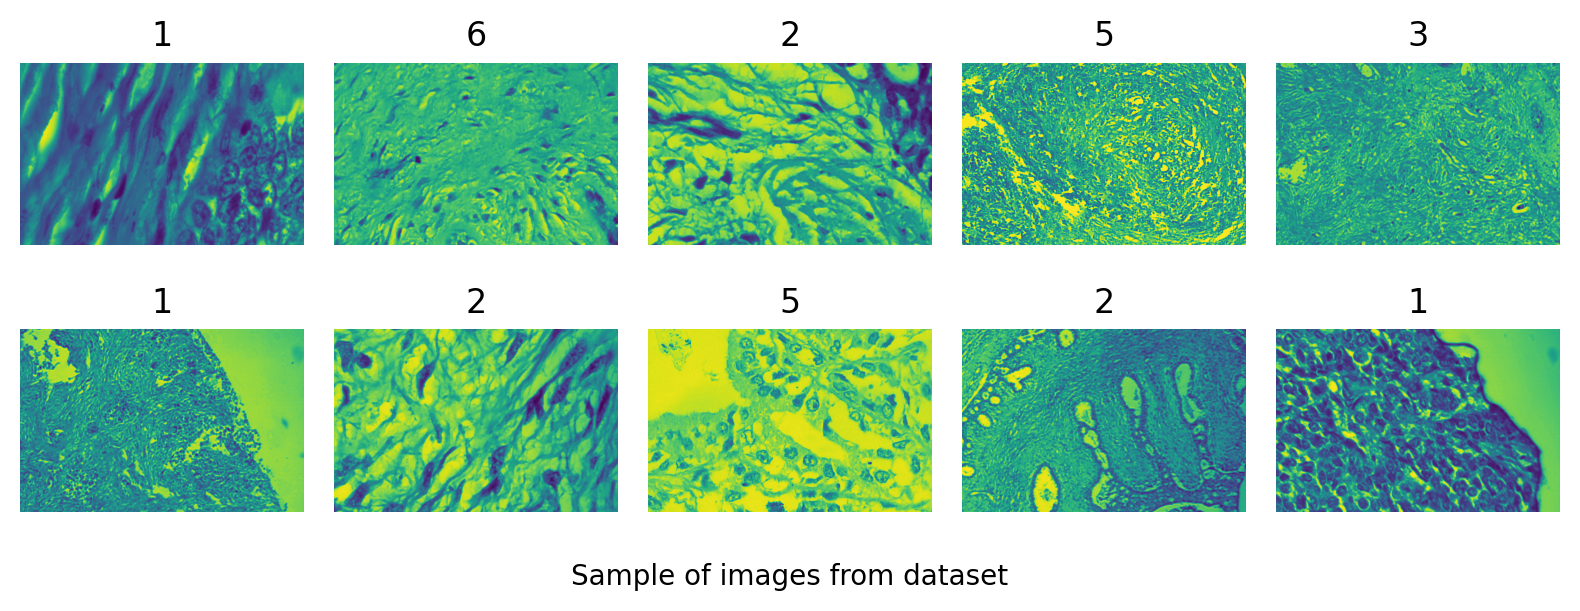

In [281]:
def augment(image, label): 
  """ """
  image, label = augment_crop(image, label)
  
  image, label = augment_grayscale(image,label)
  
  return image, label

train_ds, val_ds, test_ds = preprocess_ds(ds, read_fn = read_image, augment_fn= augment)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

train_sample = create_image_set(train_ds, num_images = 10)
plot_images(train_sample, nrows=2, ncols =5)

## Discussion on chosen features

---

# Classification (35 pts)

For our classifers we chose to use we create: 
1. CNN Binary Classifier for Benign v. Malignant
2. ResNet Classifer for 8 classes

Create at least two classifiers: 
1. SVM
2. simple perception



In [288]:
model_results = pd.DataFrame()

In [290]:
def add_model_results(hist): 
    """ Takes in history  object output from model.fit"""
    
    model_results = pd.concat([model_results, pd.DataFrame(hist.hist)])
    
    return model_results

In [ ]:
METRICS = [
      'accuracy',
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [322]:
resize_rescale_layer = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(
        128, 128, seed=seed
    )
])

data_aug_layer = tf.keras.Sequential([
    
    tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=seed),
    tf.keras.layers.RandomRotation(0.2, seed=seed),
    tf.keras.layers.RandomContrast(0.2, seed=seed),
])


# Under Sampling Method

In [323]:
def augment(image, label): 
  """ """
  image, label = augment_crop(image, label)
  
  image, label = augment_grayscale(image,label)
  
  return image, label

train_ds, val_ds, test_ds = preprocess_ds(ds_under, read_fn = read_image, augment_fn= augment)

train_ds = prepare_ds(train_ds, shuffle=True, augment=True)
val_ds = prepare_ds(val_ds)
test_ds = prepare_ds(test_ds)

# decode
train_labels = decoder(train_ds)
val_labels = decoder(val_ds)
test_labels = decoder(test_ds)

train_sample = create_image_set_batched(train_ds, batch_size = 32, num_images = 1)
plot_images(train_sample, nrows=2, ncols =5)

2486
711
710


## Base Model

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 262144)            0         
                                                                 
 dense_32 (Dense)            (None, 128)               33554560  
                                                                 
 dense_33 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 33,556,232
Trainable params: 33,556,232
Non-trainable params: 0
_________________________________________

INFO:tensorflow:Assets written to: ../models/model_grayscale\assets


INFO:tensorflow:Assets written to: ../models/model_grayscale\assets


78/78 [==============================] - 24s 306ms/step - loss: 9.7129 - accuracy: 0.1287 - val_loss: 10.3827 - val_accuracy: 0.1167
Epoch 2/5
78/78 [==============================] - 20s 261ms/step - loss: 10.0949 - accuracy: 0.1279 - val_loss: 10.3827 - val_accuracy: 0.1167
Epoch 3/5
78/78 [==============================] - ETA: 0s - loss: 10.0949 - accuracy: 0.1279

INFO:tensorflow:Assets written to: ../models/model_grayscale\assets


INFO:tensorflow:Assets written to: ../models/model_grayscale\assets


78/78 [==============================] - 23s 292ms/step - loss: 10.0949 - accuracy: 0.1279 - val_loss: 10.3827 - val_accuracy: 0.1167
Epoch 4/5
78/78 [==============================] - 21s 276ms/step - loss: 10.0949 - accuracy: 0.1279 - val_loss: 10.3827 - val_accuracy: 0.1167
Epoch 5/5
78/78 [==============================] - 21s 263ms/step - loss: 10.0949 - accuracy: 0.1279 - val_loss: 10.3827 - val_accuracy: 0.1167


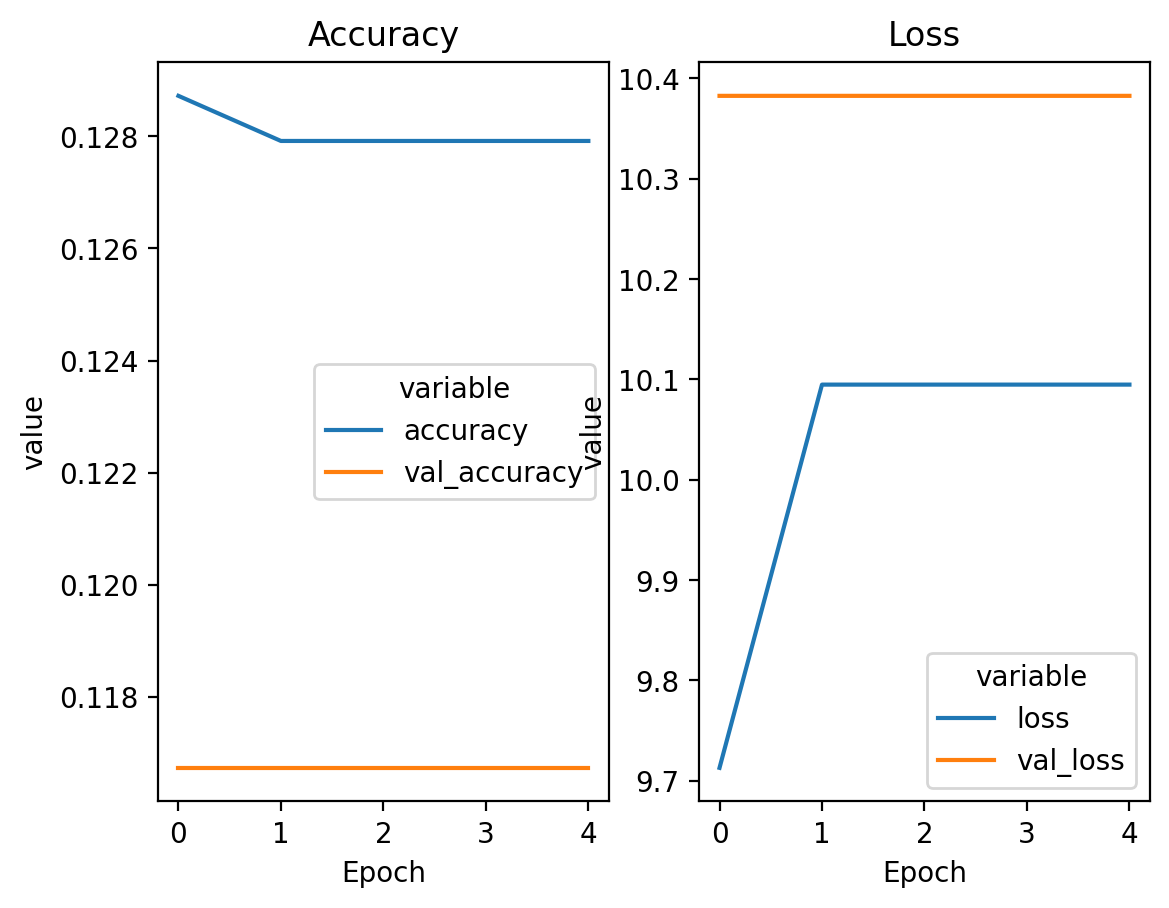

In [336]:
num_classes = 8

model_grayscale = tf.keras.Sequential([
  tf.keras.layers.Input((128, 128, 1)),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'), # same as kernel size of (3,3)
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


model_grayscale.summary()

#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=100,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)


#Compiling the model
model_grayscale.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("../models/model_grayscale/",save_best_only=True,)

tensorboard_callback = create_tf_board("model_grayscale")

#Model is fitted using train and validation generator for 200 epochs
hist = model_grayscale.fit(train_ds,
                           validation_data=val_ds,
                           epochs=5,
                           callbacks=[early_stop,checkpoint,tensorboard_callback],
                           verbose = 1)

# plot model training results
plot_hist(hist)

Confusion Matrix

In [328]:
hist_df = pd.DataFrame(hist.history)
hist_df.insert(loc=0, column='model_name', value='base_grayscale')
hist_df.iloc[-1,:]

model_name      base_grayscale
loss                  2.007221
accuracy              0.192277
val_loss              2.077144
val_accuracy          0.157525
Name: 2, dtype: object

In [330]:
results = model_grayscale.evaluate(test_ds)

23/23 [==============================] - 1s 41ms/step - loss: 2.0792 - accuracy: 0.1423


In [331]:
 model_grayscale.predict(test_ds)

23/23 [==============================] - 1s 40ms/step


array([[0.12382532, 0.12522021, 0.12438181, ..., 0.12508748, 0.12387686,
        0.12551787],
       [0.12382532, 0.12522021, 0.12438181, ..., 0.12508748, 0.12387686,
        0.12551787],
       [0.12382532, 0.12522021, 0.12438181, ..., 0.12508748, 0.12387686,
        0.12551787],
       ...,
       [0.12382532, 0.12522021, 0.12438181, ..., 0.12508748, 0.12387686,
        0.12551787],
       [0.12382532, 0.12522021, 0.12438181, ..., 0.12508748, 0.12387686,
        0.12551787],
       [0.12382532, 0.12522021, 0.12438181, ..., 0.12508748, 0.12387686,
        0.12551787]], dtype=float32)

23/23 [==============================] - 1s 39ms/step
True Negatives:  0
False Positives:  86
False Negatives:  0
True Positives:  90
Total Malignant Cases:  90


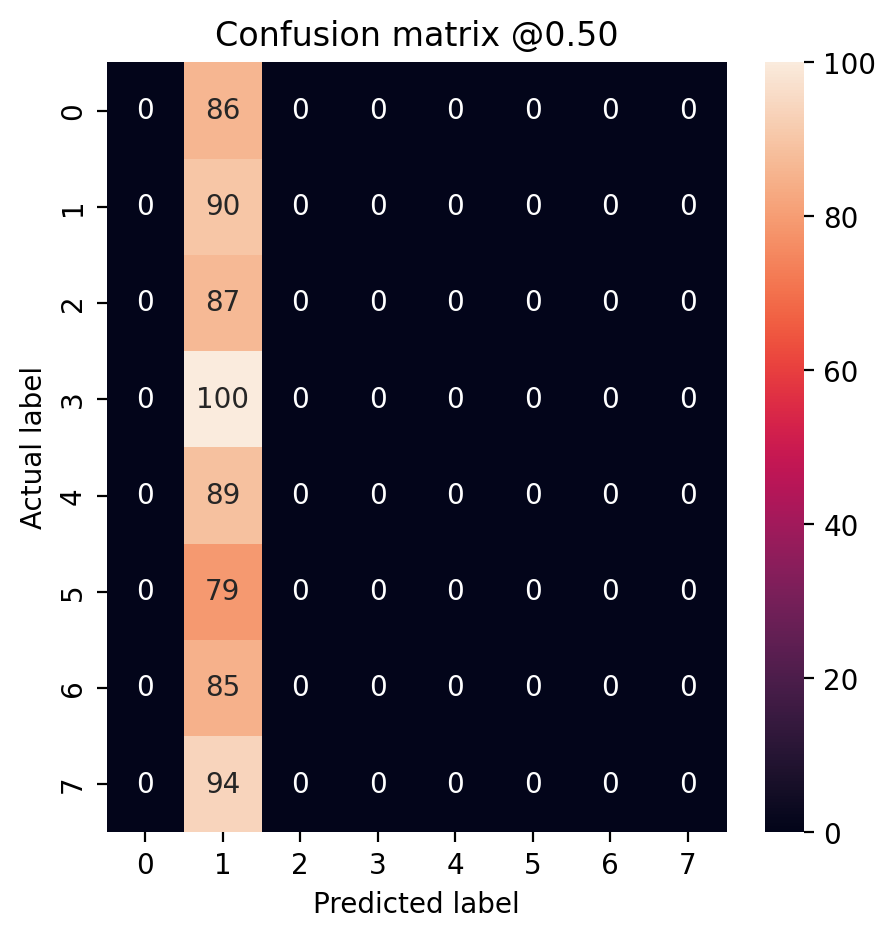

In [332]:
train_predictions = model_grayscale.predict(train_ds).argmax(axis=1)
test_predictions = model_grayscale.predict(test_ds).argmax(axis=1)
plot_cm(test_labels, test_predictions)

In [311]:
print(classification_report(test_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       103
           1       0.00      0.00      0.00        97
           2       0.00      0.00      0.00       101
           3       0.00      0.00      0.00        82
           4       0.10      1.00      0.18        70
           5       0.00      0.00      0.00        79
           6       0.00      0.00      0.00        89
           7       0.00      0.00      0.00        89

    accuracy                           0.10       710
   macro avg       0.01      0.12      0.02       710
weighted avg       0.01      0.10      0.02       710



In [121]:
save_weights(model, "simple_base_model")

In [ ]:
# # This initializes the variables used by the optimizers,
# # as well as any stateful metric variables
# my_custom_model.train_on_batch(x_train[:1], y_train[:1])

# # Load the state of the old model (to load weights for all layers)
# # my_custom_model.load_weights('path_to_my_weights')

# layer_dict = dict([(layer.name, layer) for layer in base_model.layers])
# print(layer_dict)

# # my_custom_model.trainable = True
# # loading the weights from base_model
# for layer in my_custom_model.layers:
#   layer_name = layer.name
#   #print(layer.name)
#   layer.set_weights(layer_dict[layer_name].get_weights())

# Res Net Classifier

In [ ]:
# tf.keras.applications.resnet50.ResNet50(
#     include_top=True,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     **kwargs
# )

In [ ]:
def augment_crop(image, label, height = 450, width = 700): 
    """ Crops image by defining a bounding box
    
    Using to make sure the images are the same size.     
    """
    # normalize image size to a square and get smaller subsection
    image = tf.image.random_crop(value=image, size=(height, width, 3))
    
    return image, label

In [ ]:
train_ds, val_ds, test_ds = preprocess_ds(ds, read_fn = read_image, augment_fn= augment_crop)

train_ds = prepare_ds(train_ds, shuffle=True, augment=True)
val_ds = prepare_ds(val_ds)
test_ds = prepare_ds(test_ds)

# decode
train_labels = decoder(train_ds)
val_labels = decoder(val_ds)
test_labels = decoder(test_ds)

5536
1583
1581


In [122]:
def resnet_preprocess(image, label): 
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

# i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
# x = tf.cast(i, tf.float32)
# x = tf.keras.applications.resnet50.preprocess_input(x)
# core = ttf.keras.applications.resnet50.ResNet50()
# x = core(x)
# model = tf.keras.Model(inputs=[i], outputs=[x])

# image = tf.image.decode_png(tf.io.read_file('file.png'))
# result = model(image)

In [123]:
train_ds_resnet = train_ds.map(resnet_preprocess)
val_ds_resnet = val_ds.map(resnet_preprocess)
test_ds_resnet = test_ds.map(resnet_preprocess)

In [138]:
resnet_model = tf.keras.applications.ResNet50(
    include_top = False, 
    input_shape = (128, 128, 3)
)

for layer in resnet_model.layers[0:-10]: layer.trainable = False
for layer in resnet_model.layers[-10:-1]: layer.trainable = True

94765736/94765736 [==============================] - 6s 0us/step


In [140]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(lr = learning_rate, momentum = 0.5, nesterov = True)

In [142]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(lr = learning_rate, momentum = 0.5, nesterov = True)
resnet_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer = optimizer, metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("../models/resnet_model/",save_best_only=True,)
tensorboard_callback = create_tf_board("resnet_model")
resnet_model.fit(train_ds, steps_per_epoch = 500, validation_data = val_ds, verbose = 1, epochs = 200, callbacks = [early_stop,checkpoint,tensorboard_callback])
score = resnet_model.evaluate(test_ds)

In [ ]:
score = resnet_model.evaluate(test_ds)

In [151]:
%pwd

'c:\\Users\\nickl\\Documents\\Berkeley\\W281\\Computer-Vision-281-Final-Project\\notebooks'

In [ ]:
weights = model.load_weights("./model_weights/base_model/base_model_weights.index")

In [157]:
input_shape = (128,128,3)
fine_tune = True

# weights = model.load_weights(r"C:\Users\nickl\Documents\Berkeley\W281\Computer-Vision-281-Final-Project\notebooks\model_weights\base_model")

if True: 
    baseModel = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_tensor=tf.keras.Input(shape=input_shape))
    headModel = baseModel.output
    headModel = tf.keras.layers.GlobalAveragePooling2D()(headModel)
    headModel = tf.keras.layers.Dense(1024, activation = 'relu')(headModel)
    headModel = tf.keras.layers.Dense(num_classes, activation = 'softmax')(headModel)
    model = tf.keras.Model(inputs = baseModel.input, outputs = headModel)
    if fine_tune: 
        for layer in model.layers[0:-10]: layer.trainable = False
        for layer in model.layers[-10:-1]: layer.trainable = True

In [159]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(lr = learning_rate, momentum = 0.5, nesterov = True)
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer = optimizer, metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("../models/resnet_model2/",save_best_only=True,)
tensorboard_callback = create_tf_board("resnet_model2")
model.fit(train_ds, steps_per_epoch = 500, validation_data = val_ds, verbose = 1, epochs = 200, callbacks = [early_stop,checkpoint,tensorboard_callback])
score = model.evaluate(test_ds)

Epoch 1/200
173/500 [=========>....................] - ETA: 1:37 - loss: 1.7740 - accuracy: 0.4346WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 100000 batches). You may need to use the repeat() function when building your dataset.


INFO:tensorflow:Assets written to: ../models/resnet_model2\assets


INFO:tensorflow:Assets written to: ../models/resnet_model2\assets


50/50 [==============================] - 14s 270ms/step - loss: 1.9148 - accuracy: 0.4447


repeat() function when building your dataset

In [160]:
train_ds.repeat(count=4)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

## Classifier 3: Random Forest
https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel

Amir's code

In [ ]:
# #Setting the learning rate to reduce gradually over the training period
# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#   0.001,
#   decay_steps=20*50,
#   decay_rate=1,
#   staircase=False)

# def get_optimizer():
#   return tensorflow.keras.optimizers.Adam(lr_schedule)

In [ ]:
# #Compiling the model
# cancer_model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
# early_stop = EarlyStopping(monitor='val_loss',patience=5)
# checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
# #Model is fitted using train and validation generator for 200 epochs
# history = cancer_model.fit(train_generation, validation_data=val_generation, epochs=200 ,
#                  callbacks=[early_stop,checkpoint], verbose = 1)

In [ ]:
# import tensorflow_decision_forests as tfdf

In [ ]:
# Encode the categorical labels as integers.
#
# Details:
# This stage is necessary if your classification label is represented as a
# string since Keras expects integer classification labels.
# When using `pd_dataframe_to_tf_dataset` (see below), this step can be skipped.

# Name of the label column.
# label = "TUMOR_CLASS"

# classes = df[label].unique().tolist()
# print(f"Label classes: {classes}")

# df[label] = df[label].map(classes.index)

In [ ]:
# Split the dataset into a training and a testing dataset.

# def split_dataset(dataset, test_ratio=0.30):
#   """Splits a panda dataframe in two."""
#   test_indices = np.random.rand(len(dataset)) < test_ratio
#   return dataset[~test_indices], dataset[test_indices]


# train_ds_pd, test_ds_pd = split_dataset(df)
# print("{} examples in training, {} examples for testing.".format(
#     len(train_ds_pd), len(test_ds_pd)))

In [ ]:
# train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

In [ ]:
# %set_cell_height 300

# # Specify the model.
# model_1 = tfdf.keras.RandomForestModel(verbose=2)

# # Train the model.
# model_1.fit(train_ds)

---

### Evaluate Model 

In [ ]:
# model.predict(test_ds)

## Amir's Sigmoid Model for binary classification

Here the Image Data Generator is defined with following functions:
1. Random rotation by 20 degrees.
2. Horizontal flip.
3. Vertical flip.
4. Rescale image by its pixel value.
5. Randomly Zoom image by 20%.
6. Random shear by 20%.

CNN Architecture:
1. CNN architecture is defined using Conv2D layers and Maxpooling layers.
2. Dropout Layers are added to randomly turn off some neurons while training to prevent from overfitting.
3. Flatten layer is added at the end to form Dense Layers.
4. relu is used as activation in all the layers and Sigmoid as the activation in the output layer.

In [337]:
def raw_labels(ds):
    """ For binary classification models """
    y = np.concatenate([y for x, y in ds], axis=0) # works since ds is batched
    return y

In [352]:
df['TUMOR_CLASS']

0       B
1       B
2       B
3       B
4       B
       ..
7904    M
7905    M
7906    M
7907    M
7908    M
Name: TUMOR_CLASS, Length: 7909, dtype: object

In [359]:
x = df[['FULL_PATH']]
y = df['TUMOR_CLASS'].replace({'B':0, 'M':1})

rus = RandomUnderSampler()

x_under, y_under = rus.fit_resample(x,y)

df_under = pd.concat([x_under, y_under], axis=1)

del x_under, y_under

df_under.TUMOR_CLASS.value_counts()

# Binary classification
def augment(image, label): 
  """ """
  image, label = augment_crop(image, label)
  
  # image, label = augment_grayscale(image,label)
  
  return image, label

ds_under = create_tf_ds(df_under['FULL_PATH'], df_under['TUMOR_CLASS'])

train_ds, val_ds, test_ds = preprocess_ds(ds_under, read_fn = read_image, augment_fn= augment)

train_ds = prepare_ds(train_ds, shuffle=True, augment=True)
val_ds = prepare_ds(val_ds)
test_ds = prepare_ds(test_ds)

# decode
train_binary_labels = raw_labels(train_ds_binary)
val_binary_labels = raw_labels(val_ds_binary)
test_binary_labels = raw_labels(test_ds_binary)

# train_sample = create_image_set_batched(train_ds, batch_size = 32, num_images = 1)
# plot_images(train_sample, nrows=2, ncols =5)



0    2480
1    2480
Name: TUMOR_CLASS, dtype: int64

In [126]:
# #Defining Image Data Generator
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     horizontal_flip=True,
#     vertical_flip=True,
#     rescale=1./255,
#     shear_range=0.2,
#     fill_mode='nearest',
#     zoom_range=0.2)

# #Setting up the images for image data generator
# train_binary = datagen.flow_from_directory("G:/My Drive/w281_final_project/Data/AmirData/Cancer_train/",target_size=(128,128),batch_size = 32, class_mode="binary")
# val_binary = datagen.flow_from_directory("G:/My Drive/w281_final_project/Data/AmirData/Cancer_validation/", target_size=(128,128), batch_size=32, class_mode="binary")

# #Loading the test data using Image Data Generator
# test_binary = datagen.flow_from_directory("G:/My Drive/w281_final_project/Data/AmirData/Cancer_test/", target_size=(128,128), class_mode="binary", batch_size=1, shuffle=False)

Found 8800 images belonging to 2 classes.
Found 712 images belonging to 2 classes.
Found 791 images belonging to 2 classes.


In [ ]:
# standardizaton_flag = True
# if standardizaton_flag:
#     train_binary.

In [410]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [412]:
def create_cancer_model(): 
    # #Defining the base model 
        
    model = tf.keras.Sequential([        
        # CNN
        tf.keras.layers.Input(shape = (224, 224, 3)),
        Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding='same'),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding='same'),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding='same'),
        MaxPooling2D(pool_size = (2,2)),
        Dropout(0.4),
        Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding='same'),
        MaxPooling2D(pool_size = (2,2)),
        Dropout(0.4),
        Flatten(),
        Dense(256, activation = 'relu'),
        Dense(125, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
        ])
    
    model.summary()    
    
    return model

In [413]:
cancer_model_unbalanced_classes = create_cancer_model()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_73 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_75 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 16, 16, 32)     

In [414]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.1,
  decay_steps=100,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)


#Compiling the model
cancer_model_unbalanced_classes.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("../models/cancer_model_unbalanced_classes/",save_best_only=True,)

tensorboard_callback = create_tf_board("cancer_model_binary_class_balance")

#Model is fitted using train and validation generator for 200 epochs
history = cancer_model_unbalanced_classes.fit(train_ds,
                           validation_data=val_ds,
                           epochs=200,
                           callbacks=[early_stop,checkpoint,tensorboard_callback],
                           verbose = 1)

Epoch 1/200
108/109 [============================>.] - ETA: 0s - loss: 0.6708 - accuracy: 0.5917

INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


109/109 [==============================] - 37s 236ms/step - loss: 0.6705 - accuracy: 0.5922 - val_loss: 0.6203 - val_accuracy: 0.7056
Epoch 2/200
109/109 [==============================] - ETA: 0s - loss: 0.5342 - accuracy: 0.7673

INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


109/109 [==============================] - 15s 141ms/step - loss: 0.5342 - accuracy: 0.7673 - val_loss: 0.5195 - val_accuracy: 0.7984
Epoch 3/200
108/109 [============================>.] - ETA: 0s - loss: 0.4989 - accuracy: 0.7827

INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


109/109 [==============================] - 14s 132ms/step - loss: 0.4983 - accuracy: 0.7834 - val_loss: 0.5157 - val_accuracy: 0.7873
Epoch 4/200
109/109 [==============================] - ETA: 0s - loss: 0.4853 - accuracy: 0.7909

INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


109/109 [==============================] - 14s 125ms/step - loss: 0.4853 - accuracy: 0.7909 - val_loss: 0.5051 - val_accuracy: 0.7923
Epoch 5/200
109/109 [==============================] - ETA: 0s - loss: 0.4789 - accuracy: 0.8004

INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


109/109 [==============================] - 15s 136ms/step - loss: 0.4789 - accuracy: 0.8004 - val_loss: 0.4956 - val_accuracy: 0.7964
Epoch 6/200
109/109 [==============================] - 11s 101ms/step - loss: 0.4755 - accuracy: 0.7995 - val_loss: 0.4957 - val_accuracy: 0.7944
Epoch 7/200
108/109 [============================>.] - ETA: 0s - loss: 0.4696 - accuracy: 0.8053

INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


109/109 [==============================] - 13s 123ms/step - loss: 0.4707 - accuracy: 0.8047 - val_loss: 0.4917 - val_accuracy: 0.7933
Epoch 8/200
109/109 [==============================] - 11s 99ms/step - loss: 0.4682 - accuracy: 0.8021 - val_loss: 0.4973 - val_accuracy: 0.7944
Epoch 9/200
109/109 [==============================] - 11s 100ms/step - loss: 0.4687 - accuracy: 0.8059 - val_loss: 0.4944 - val_accuracy: 0.7964
Epoch 10/200
109/109 [==============================] - 11s 101ms/step - loss: 0.4649 - accuracy: 0.8039 - val_loss: 0.4979 - val_accuracy: 0.7893
Epoch 11/200
108/109 [============================>.] - ETA: 0s - loss: 0.4638 - accuracy: 0.8061

INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


109/109 [==============================] - 14s 129ms/step - loss: 0.4636 - accuracy: 0.8062 - val_loss: 0.4907 - val_accuracy: 0.7984
Epoch 12/200
109/109 [==============================] - ETA: 0s - loss: 0.4657 - accuracy: 0.8039

INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


109/109 [==============================] - 14s 127ms/step - loss: 0.4657 - accuracy: 0.8039 - val_loss: 0.4887 - val_accuracy: 0.7974
Epoch 13/200
109/109 [==============================] - 11s 100ms/step - loss: 0.4639 - accuracy: 0.8090 - val_loss: 0.4927 - val_accuracy: 0.7964
Epoch 14/200
109/109 [==============================] - 11s 104ms/step - loss: 0.4644 - accuracy: 0.8041 - val_loss: 0.4947 - val_accuracy: 0.7933
Epoch 15/200
109/109 [==============================] - ETA: 0s - loss: 0.4663 - accuracy: 0.8041

INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


INFO:tensorflow:Assets written to: ../models/cancer_model_unbalanced_classes\assets


109/109 [==============================] - 13s 122ms/step - loss: 0.4663 - accuracy: 0.8041 - val_loss: 0.4857 - val_accuracy: 0.7933
Epoch 16/200
109/109 [==============================] - 11s 103ms/step - loss: 0.4629 - accuracy: 0.8062 - val_loss: 0.4872 - val_accuracy: 0.7984
Epoch 17/200
109/109 [==============================] - 11s 99ms/step - loss: 0.4619 - accuracy: 0.8059 - val_loss: 0.4871 - val_accuracy: 0.7984
Epoch 18/200
109/109 [==============================] - 11s 103ms/step - loss: 0.4614 - accuracy: 0.8082 - val_loss: 0.4872 - val_accuracy: 0.7994
Epoch 19/200
109/109 [==============================] - 11s 101ms/step - loss: 0.4615 - accuracy: 0.8041 - val_loss: 0.4864 - val_accuracy: 0.7994
Epoch 20/200
109/109 [==============================] - 12s 106ms/step - loss: 0.4613 - accuracy: 0.8059 - val_loss: 0.4863 - val_accuracy: 0.7994


In [415]:
save_weights(cancer_model_unbalanced_classes, "cancer_model_unbalanced_classes")

In [418]:
test_labels.shape

(710,)

In [419]:
test_predictions.shape

(1581,)

50/50 [==============================] - 1s 22ms/step
True Negatives:  139
False Positives:  361
False Negatives:  298
True Positives:  783
Total Malignant Cases:  1081


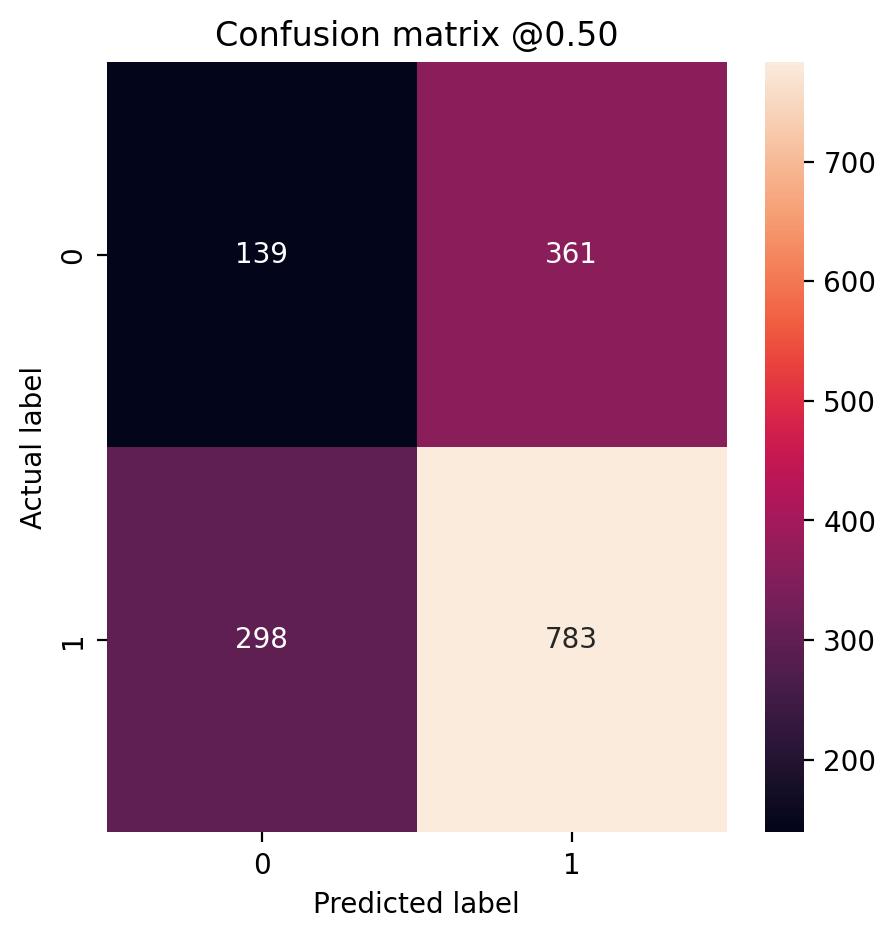

In [420]:
results = cancer_model_unbalanced_classes.evaluate(test_ds_binary)

train_predictions = (cancer_model_unbalanced_classes.predict(train_ds_binary) > 0.5).astype("int32")
train_predictions = train_predictions.flatten()

test_predictions = (cancer_model_unbalanced_classes.predict(test_ds_binary) > 0.5).astype("int32")
test_predictions = test_predictions.flatten()
plot_cm(test_binary_labels, test_predictions)

In [423]:
sm = SMOTEN()
x_over, y_over = sm.fit_resample(x,y)
df_over_smote = pd.concat([x_over,y_over], axis = 1)
del x_over, y_over
df_over_smote.TUMOR_CLASS.value_counts()

# Binary classification
def augment(image, label): 
  """ """
  image, label = augment_crop(image, label)
  
  # image, label = augment_grayscale(image,label)
  
  return image, label

ds_over = create_tf_ds(df_over_smote['FULL_PATH'], df_over_smote['TUMOR_CLASS'])

train_ds, val_ds, test_ds = preprocess_ds(ds_over, read_fn = read_image, augment_fn= augment)

train_ds = prepare_ds(train_ds, shuffle=True, augment=True)
val_ds = prepare_ds(val_ds)
test_ds = prepare_ds(test_ds)

# decode
train_binary_labels = raw_labels(train_ds_binary)
val_binary_labels = raw_labels(val_ds_binary)
test_binary_labels = raw_labels(test_ds_binary)

# train_sample = create_image_set_batched(train_ds, batch_size = 32, num_images = 1)
# plot_images(train_sample, nrows=2, ncols =5)

7600
2173
2171


In [424]:
cancer_model_over_sampled = create_cancer_model()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 16, 16, 32)     

In [425]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=100,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)


#Compiling the model
cancer_model_balanced_classes.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("../models/cancer_model_over_sampled/",save_best_only=True,)

tensorboard_callback = create_tf_board("cancer_model_over_sampled")

#Model is fitted using train and validation generator for 200 epochs
history = cancer_model_balanced_classes.fit(train_binary,
                           validation_data=val_binary,
                           epochs=200,
                           callbacks=[early_stop,checkpoint,tensorboard_callback],
                           verbose = 1)

Epoch 1/200
  2/275 [..............................] - ETA: 1:32:19 - loss: 0.7587 - accuracy: 0.5625

In [ ]:
cancer_model_balanced_classes.save("../models/cancer_model_balanced_classes/binary_cnn_balanced_classes.h5")

In [ ]:
save_weights(model, "cancer_model_balanced_classes")

50/50 [==============================] - 1s 21ms/step
True Negatives:  123
False Positives:  364
False Negatives:  276
True Positives:  818
Total Malignant Cases:  1094


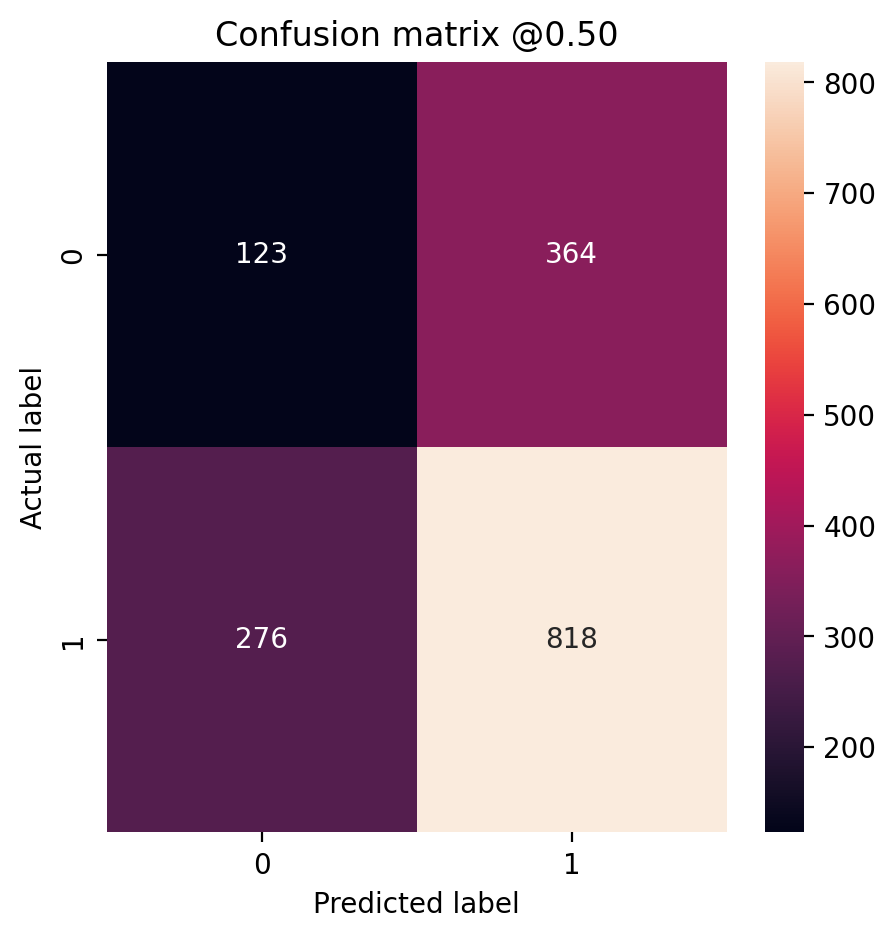

In [ ]:
results = cancer_model_balanced_classes.evaluate(test_ds_binary)

train_predictions = (cancer_model_balanced_classes.predict(train_ds_binary) > 0.5).astype("int32")
train_predictions = train_predictions.flatten()

test_predictions = (cancer_model_balanced_classes.predict(test_ds_binary) > 0.5).astype("int32")
test_predictions = test_predictions.flatten()
plot_cm(test_labels, test_predictions)

True Negatives:  471
False Positives:  1243
False Negatives:  1077
True Positives:  2745
Total Malignant Cases:  3822


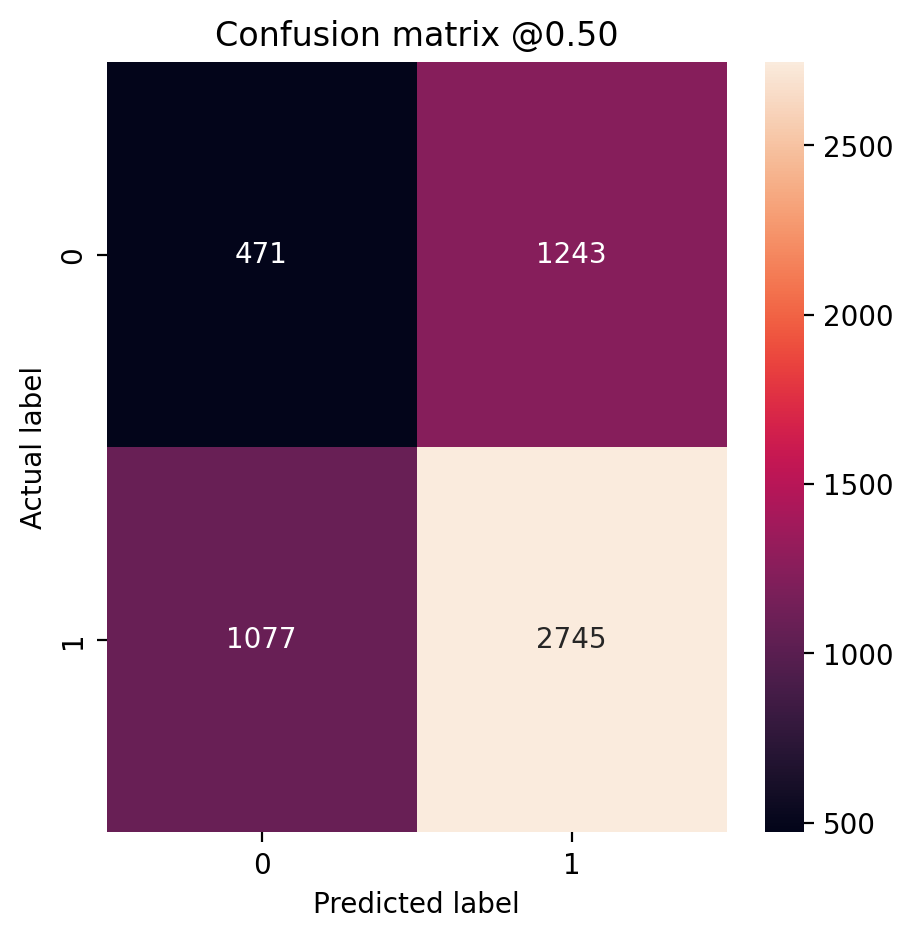

In [ ]:
plot_cm(train_labels, train_predictions)

Tensor board

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/cancer_model_binary

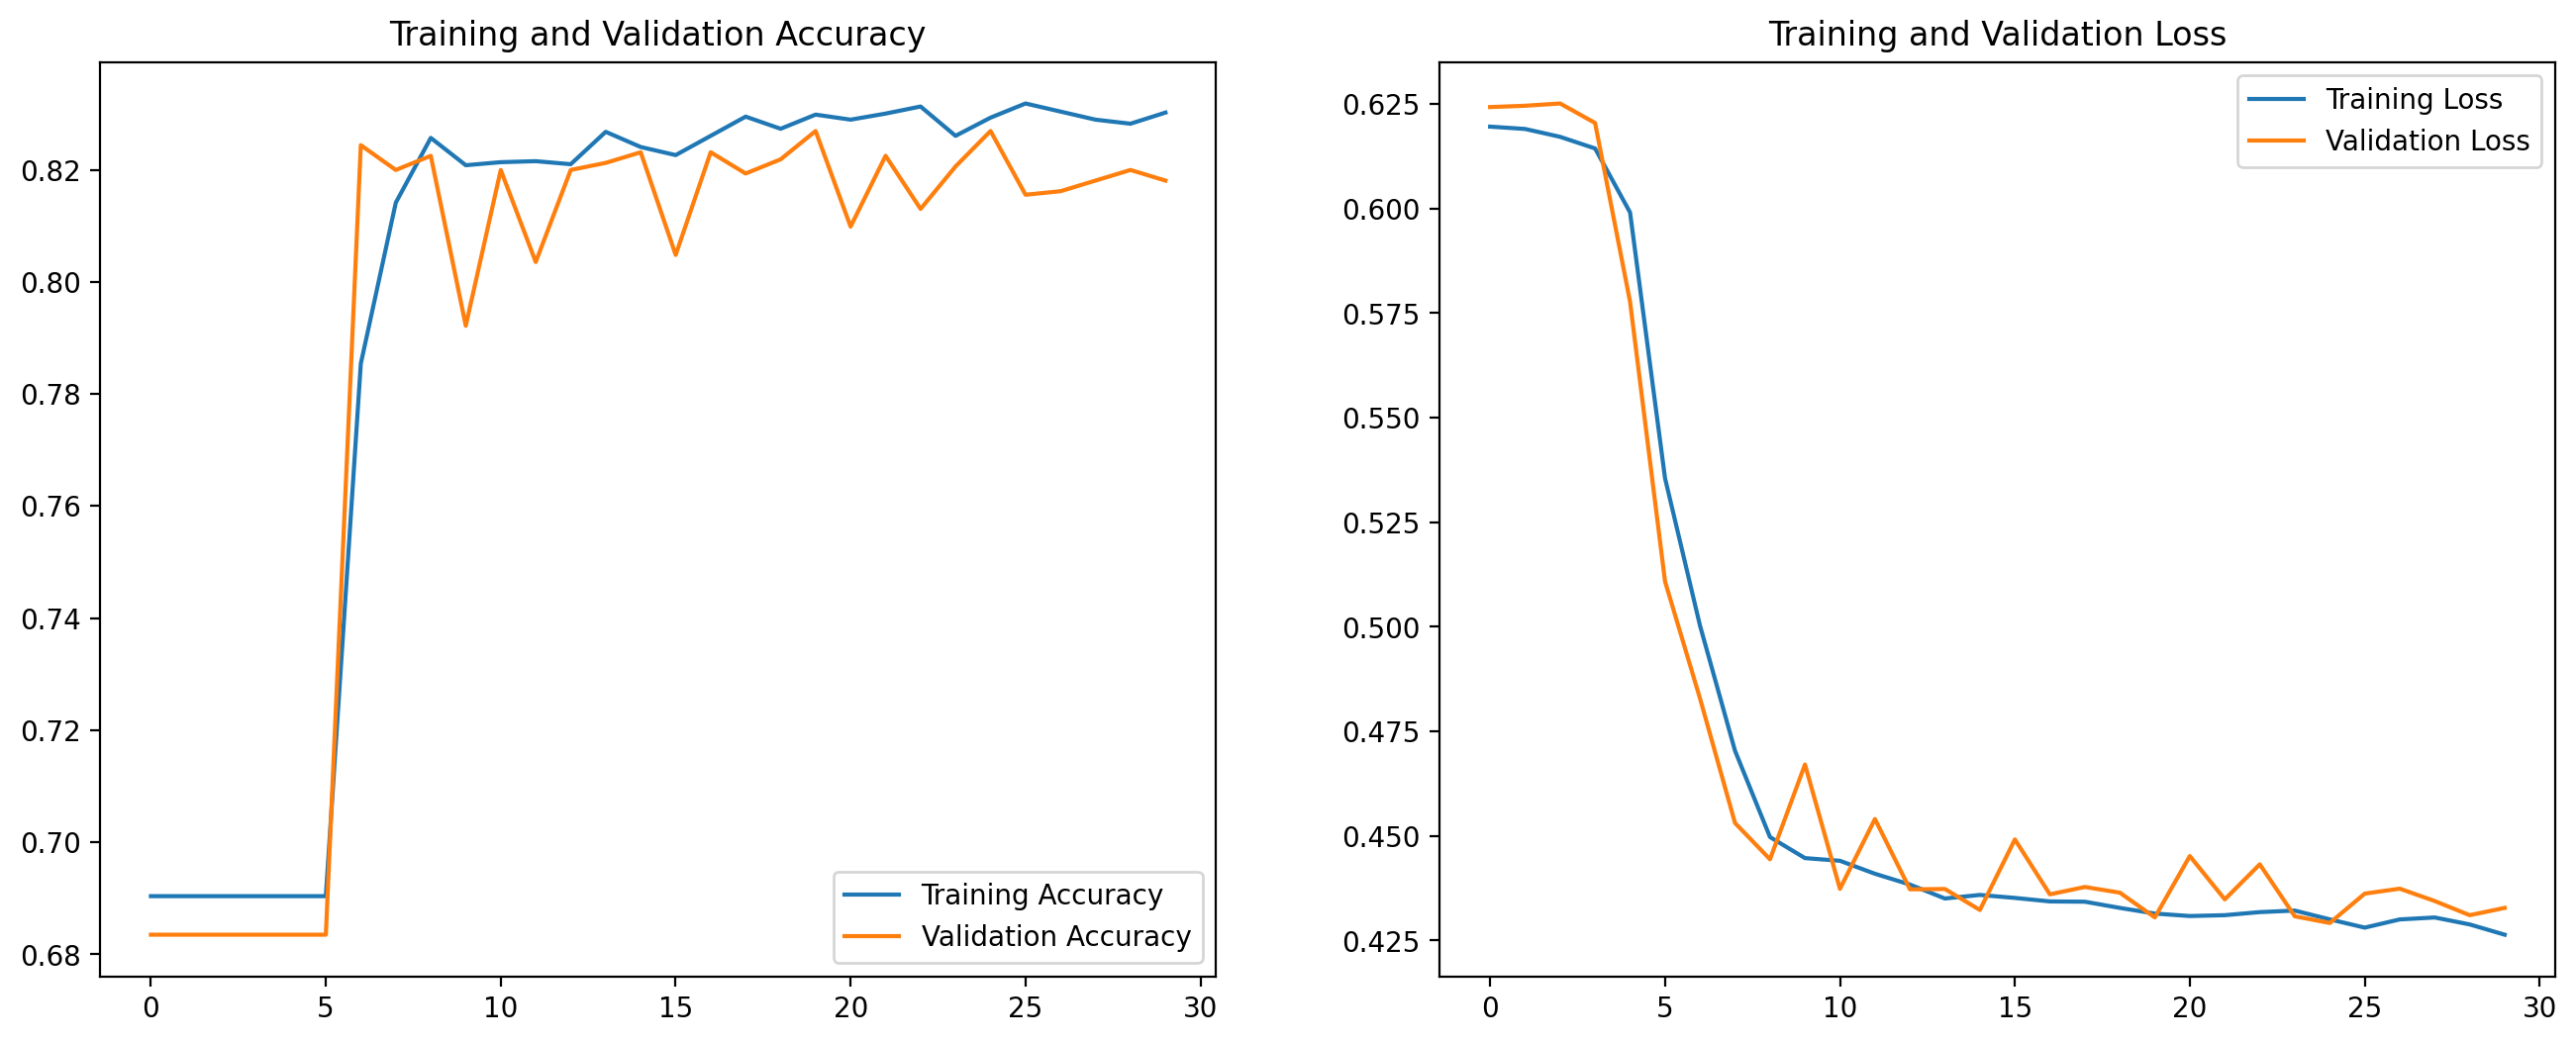

In [ ]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Amir Multiclass Model

In [ ]:
def create_cancer_model_multiclass(): 
    """Create cancer multiclassification model"""
    
    model = tf.keras.Sequential([        
        # CNN
        tf.keras.layers.Input(shape = (224, 224, 3)),
        Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
        MaxPooling2D(pool_size = (2,2)),
        Dropout(0.4),
        Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
        MaxPooling2D(pool_size = (2,2)),
        Dropout(0.4),
        Flatten(),
        Dense(256, activation = 'relu'),
        Dense(125, activation = 'relu'),
        Dense(8, activation = 'sigmoid')
        ])
    
    model.summary()    
    
    return model

In [ ]:
create_cancer_model_multiclass = create_cancer_model_multiclass()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 32)      

In [ ]:
model_name = "am_multiclassification_unbalanced_model"

#Compiling the model
create_cancer_model_multiclass.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint(f"../models/{model_name}/",save_best_only=True,)

tensorboard_callback = create_tf_board(model_name)

#Model is fitted using train and validation generator for 200 epochs
history = create_cancer_model_multiclass.fit(train_ds,
                           validation_data=val_ds,
                           epochs=200,
                           callbacks=[early_stop,checkpoint,tensorboard_callback],
                           verbose = 1)

results = create_cancer_model_multiclass.evaluate(test_ds)

train_predictions = create_cancer_model_multiclass.predict(train_ds).argmax(axis=1)
test_predictions = create_cancer_model_multiclass.predict(test_ds).argmax(axis=1)


Epoch 1/200
173/173 [==============================] - ETA: 0s - loss: 1.7919 - accuracy: 0.4294

INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


173/173 [==============================] - 20s 107ms/step - loss: 1.7919 - accuracy: 0.4294 - val_loss: 1.7581 - val_accuracy: 0.4403
Epoch 2/200
173/173 [==============================] - 15s 86ms/step - loss: 1.7715 - accuracy: 0.4321 - val_loss: 1.7722 - val_accuracy: 0.4403
Epoch 3/200
173/173 [==============================] - 15s 83ms/step - loss: 1.7701 - accuracy: 0.4321 - val_loss: 1.7818 - val_accuracy: 0.4403
Epoch 4/200
173/173 [==============================] - ETA: 0s - loss: 1.7552 - accuracy: 0.4321

INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


173/173 [==============================] - 17s 98ms/step - loss: 1.7552 - accuracy: 0.4321 - val_loss: 1.7100 - val_accuracy: 0.4403
Epoch 5/200
173/173 [==============================] - ETA: 0s - loss: 1.7288 - accuracy: 0.4321

INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


173/173 [==============================] - 18s 101ms/step - loss: 1.7288 - accuracy: 0.4321 - val_loss: 1.6752 - val_accuracy: 0.4403
Epoch 6/200
173/173 [==============================] - ETA: 0s - loss: 1.6948 - accuracy: 0.4321

INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


173/173 [==============================] - 17s 98ms/step - loss: 1.6948 - accuracy: 0.4321 - val_loss: 1.6602 - val_accuracy: 0.4403
Epoch 7/200
173/173 [==============================] - ETA: 0s - loss: 1.6658 - accuracy: 0.4442

INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


173/173 [==============================] - 17s 97ms/step - loss: 1.6658 - accuracy: 0.4442 - val_loss: 1.6196 - val_accuracy: 0.4769
Epoch 8/200
173/173 [==============================] - ETA: 0s - loss: 1.6342 - accuracy: 0.4594

INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


173/173 [==============================] - 17s 98ms/step - loss: 1.6342 - accuracy: 0.4594 - val_loss: 1.6004 - val_accuracy: 0.4940
Epoch 9/200
173/173 [==============================] - 15s 84ms/step - loss: 1.6098 - accuracy: 0.4727 - val_loss: 1.6422 - val_accuracy: 0.4864
Epoch 10/200
173/173 [==============================] - ETA: 0s - loss: 1.5805 - accuracy: 0.4868

INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


173/173 [==============================] - 18s 105ms/step - loss: 1.5805 - accuracy: 0.4868 - val_loss: 1.5606 - val_accuracy: 0.5066
Epoch 11/200
173/173 [==============================] - 15s 84ms/step - loss: 1.5638 - accuracy: 0.4886 - val_loss: 1.5984 - val_accuracy: 0.4833
Epoch 12/200
173/173 [==============================] - ETA: 0s - loss: 1.5449 - accuracy: 0.4960

INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


173/173 [==============================] - 17s 96ms/step - loss: 1.5449 - accuracy: 0.4960 - val_loss: 1.5159 - val_accuracy: 0.5111
Epoch 13/200
173/173 [==============================] - 14s 83ms/step - loss: 1.5475 - accuracy: 0.4953 - val_loss: 1.5193 - val_accuracy: 0.5155
Epoch 14/200
173/173 [==============================] - 15s 84ms/step - loss: 1.5320 - accuracy: 0.4980 - val_loss: 1.5532 - val_accuracy: 0.4940
Epoch 15/200
173/173 [==============================] - ETA: 0s - loss: 1.5204 - accuracy: 0.5014

INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


173/173 [==============================] - 18s 103ms/step - loss: 1.5204 - accuracy: 0.5014 - val_loss: 1.5084 - val_accuracy: 0.5161
Epoch 16/200
173/173 [==============================] - 14s 81ms/step - loss: 1.5413 - accuracy: 0.4931 - val_loss: 1.5252 - val_accuracy: 0.5117
Epoch 17/200
173/173 [==============================] - 15s 84ms/step - loss: 1.5225 - accuracy: 0.4980 - val_loss: 1.5503 - val_accuracy: 0.4978
Epoch 18/200
173/173 [==============================] - ETA: 0s - loss: 1.5278 - accuracy: 0.4977

INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


173/173 [==============================] - 18s 102ms/step - loss: 1.5278 - accuracy: 0.4977 - val_loss: 1.5007 - val_accuracy: 0.5148
Epoch 19/200
173/173 [==============================] - 14s 84ms/step - loss: 1.5129 - accuracy: 0.5045 - val_loss: 1.5013 - val_accuracy: 0.5136
Epoch 20/200
173/173 [==============================] - ETA: 0s - loss: 1.5169 - accuracy: 0.5033

INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


173/173 [==============================] - 17s 99ms/step - loss: 1.5169 - accuracy: 0.5033 - val_loss: 1.4936 - val_accuracy: 0.5104
Epoch 21/200
173/173 [==============================] - 14s 83ms/step - loss: 1.5142 - accuracy: 0.5020 - val_loss: 1.5696 - val_accuracy: 0.4915
Epoch 22/200
173/173 [==============================] - ETA: 0s - loss: 1.5101 - accuracy: 0.5051

INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


INFO:tensorflow:Assets written to: ../models/am_multiclassification_unbalanced_model\assets


173/173 [==============================] - 18s 103ms/step - loss: 1.5101 - accuracy: 0.5051 - val_loss: 1.4890 - val_accuracy: 0.5174
Epoch 23/200
173/173 [==============================] - 16s 95ms/step - loss: 1.5146 - accuracy: 0.5031 - val_loss: 1.5295 - val_accuracy: 0.5060
Epoch 24/200
173/173 [==============================] - 16s 90ms/step - loss: 1.5141 - accuracy: 0.4998 - val_loss: 1.4906 - val_accuracy: 0.5104
Epoch 25/200
173/173 [==============================] - 15s 86ms/step - loss: 1.5097 - accuracy: 0.5033 - val_loss: 1.5201 - val_accuracy: 0.5073
Epoch 26/200
173/173 [==============================] - 15s 89ms/step - loss: 1.5060 - accuracy: 0.5040 - val_loss: 1.5000 - val_accuracy: 0.5085
Epoch 27/200
50/50 [==============================] - 1s 20ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

True Negatives:  0
False Positives:  80
False Negatives:  0
True Positives:  682
Total Malignant Cases:  682


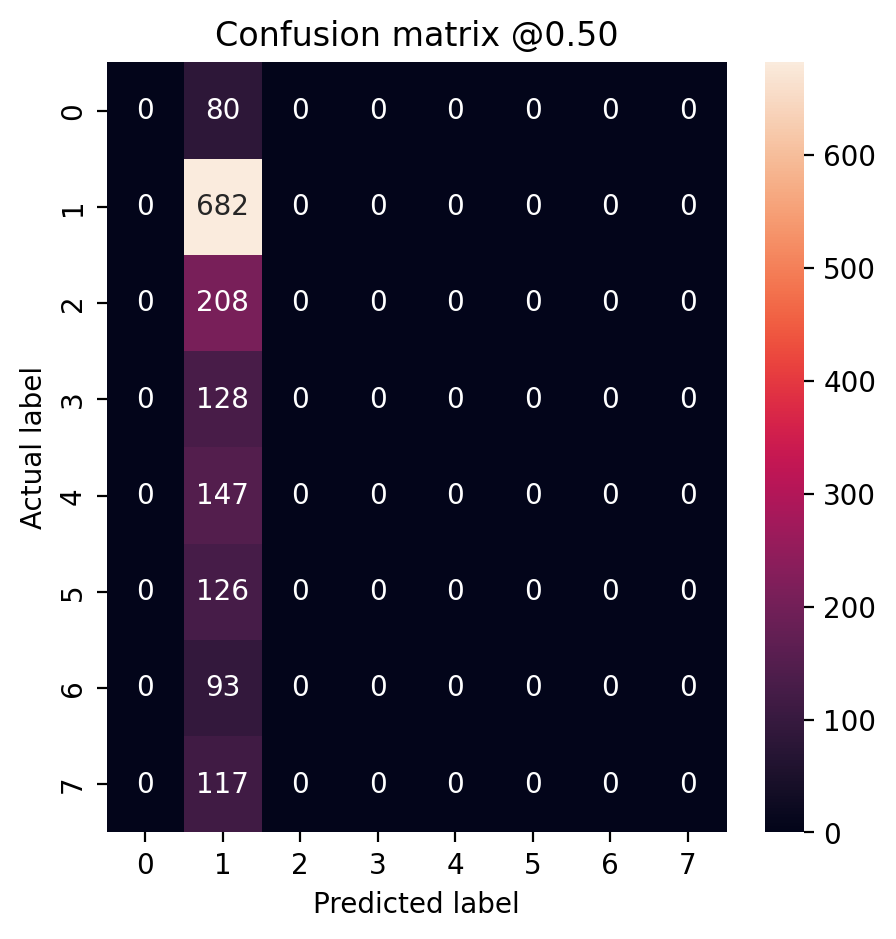

In [ ]:
plot_cm(test_labels.argmax(axis=1), test_predictions)

## Nic's Models

In [ ]:
# Binary classification
labels_binary = df['TUMOR_CLASS'].values
labels_binary = df['TUMOR_CLASS'].replace({'B':0, 'M':1}).values
# create dataset (ds)
ds_binary = create_tf_ds(file_paths, labels_binary)

# split data
train_ds_binary, val_ds_binary, test_ds_binary = preprocess_ds(ds_binary)

5536
1583
1581


#### Image Augmentation

In [ ]:
from skimage.feature import hog
from scipy import signal
from scipy.ndimage import convolve
import tensorflow_addons as tfa

In [ ]:
def get_tensor_image_labels(ds): 
    """ Extract image arrays and labels from tensor dataset """
    
    imgs = np.concatenate([x for x, y in ds], axis=0)
    labels = np.concatenate([y for x, y in ds], axis=0)
    return imgs, labels

In [ ]:
train_imgs, train_labels = get_tensor_image_labels(train_ds)
val_imgs, val_labels = get_tensor_image_labels(val_ds)
test_imgs, test_labels = get_tensor_image_labels(test_ds)

In [ ]:
### Histogram Equalization Contrast
def histogram_equalization(im):
  img_cdf, bins = exposure.cumulative_distribution(im, 256)
  container = np.zeros(256)
  container[bins] = img_cdf
  holding_image = np.empty(im.shape)
  for i in range(im.shape[0]):
    for y in range(im.shape[1]):
      holding_image[i][y] = container[im[i][y]]
  equalized_image = holding_image
  equalized_image = img_as_ubyte(equalized_image) 
  return equalized_image

In [ ]:
train_ds_binary.map(lambda x, y: (histogram_equalization(x), y),num_parallel_calls=AUTOTUNE)

AttributeError: in user code:

    File "C:\Users\nickl\AppData\Local\Temp\ipykernel_25952\2345056120.py", line 1, in None  *
        lambda x, y: (histogram_equalization(x), y)
    File "C:\Users\nickl\AppData\Local\Temp\ipykernel_25952\332610631.py", line 3, in histogram_equalization  *
        img_cdf, bins = exposure.cumulative_distribution(im, 256)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\skimage\exposure\exposure.py", line 342, in cumulative_distribution  *
        hist, bin_centers = histogram(image, nbins)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\skimage\_shared\utils.py", line 191, in fixed_func  *
        return func(*args, **kwargs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\skimage\exposure\exposure.py", line 266, in histogram  *
        hist, bin_centers = _histogram(image, nbins, source_range, normalize)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\skimage\exposure\exposure.py", line 291, in _histogram  *
        image = image.flatten()

    AttributeError: 'Tensor' object has no attribute 'flatten'


In [ ]:
""" create a 2-D gaussian blurr filter for a given mean and std """
def create_2d_gaussian(size=9, std=1.5):
    gaussian_1d = signal.gaussian(size,std=std)
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    gaussian_2d = gaussian_2d/(gaussian_2d.sum())
    return gaussian_2d

In [ ]:
def sharpen_image(image):
  # Blur filter from previous work
  h = np.array([[0.0751, 0.1238, 0.0751], 
              [0.1238, 0.2042, 0.1238],
              [0.0751, 0.1238, 0.0751]])
  blurred_image = convolve(image, h)
  high_frequency_image = np.subtract(image, blurred_image)
  sharpened_image = np.add(image, high_frequency_image)
  return sharpened_image

In [ ]:
def edge_detection(image):
  # Construct a HOG for each image and edge detection

  filter = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
  gradients = sc.ndimage.convolve(image, filter)

  histograms = hog(image, orientations = 7, pixels_per_cell=(16,16))

  return gradients, histograms

In [ ]:
### Create image arrays for inputs into the model using histogram equalization
def equalized_images_manually(image_paths):
  image_array = []
  # img1 = tf.io.read_file(image_paths)
  for i in image_paths:
    img1 = tf.keras.utils.load_img(i, color_mode='grayscale', target_size=(460, 700))
    img1 = tf.keras.utils.img_to_array(img1, dtype=int)
    img1 = histogram_equalization(img1)
    img1 = tf.cast(img1, tf.int32) /255
    image_array.append(img1)
  image_array = np.array(image_array)
  return image_array

In [ ]:
### Create image arrays for inputs into the model using histogram equalization
def equalized_images(image, label):
  image = tf.image.rgb_to_grayscale(image)
#   image = tf.keras.preprocessing.image.img_to_array(image)
  image = tfa.image.equalize(image)
  return image, label

In [ ]:
train_ds_binary.map(equalized_images)

NameError: in user code:

    File "C:\Users\nickl\AppData\Local\Temp\ipykernel_25952\3223590338.py", line 5, in equalized_images  *
        image = tfa.image.equalize(image)

    NameError: name 'tfa' is not defined


# Image Augmentation

# Models

### Baseline CNN

In [ ]:
### Baseline TensorFlow model
def create_baseline_cnn(input_shape = (450,700,1), hidden_layers = 0, filters = 4, kernel_size = 3, learning_rate = 0.001, embedding_size = 0):
  
  input_layer = tf.keras.layers.Input(input_shape, batch_size=3, name="Input_Layer")
  convolve_layer = tf.keras.layers.Conv2D(filters=5, kernel_size=3, activation='relu')(input_layer)
  drop_layer = tf.keras.layers.Dropout(0.03)(convolve_layer)
  convolve_layer_2 = tf.keras.layers.Conv2D(filters= filters, kernel_size=3, activation='relu')(drop_layer)
  flatten = tf.keras.layers.Flatten()(convolve_layer_2)
  compress = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)
  base_model = tf.keras.Model(inputs=[input_layer], outputs=[compress])
  base_model.compile(optimizer='sgd', loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

  return base_model

### Average CNN

In [ ]:
### Baseline Average CNN Model
def create_average_cnn(input_shape = (450, 700, 1), hidden_layers = 3, filters = 3, kernel_size = 3, learning_rate = 0.001, dropout_rate = 0.1):

  input_layer = tf.keras.layers.Input(shape=input_shape, batch_size = 3, name="Starting_Layer")

  # for i in range(hidden_layers):
  convolve1 = tf.keras.layers.Conv2D(filters=128, kernel_size=kernel_size, activation="ReLU", name = "Average_layer")(input_layer)
  avg_layer = tf.keras.layers.AveragePooling2D()(convolve1)
  convolve2 = tf.keras.layers.Conv2D(filters=64, kernel_size=kernel_size, activation="ReLU")(avg_layer)
  avg_layer = tf.keras.layers.AveragePooling2D()(convolve2)
  convolve3 = tf.keras.layers.Conv2D(filters=32, kernel_size=kernel_size, padding='valid', activation='relu')(avg_layer)
  avg_layer = tf.keras.layers.AveragePooling2D()(convolve3)
  avg_layer = tf.keras.layers.Dropout(dropout_rate)(avg_layer)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(avg_layer)
  # flatten_layer = tf.keras.layers.Flatten()(global_average_layer)
  avg_layer = tf.keras.layers.Dropout(dropout_rate)(global_average_layer)
  compress_layer = tf.keras.layers.Dense(8, activation = "ReLU")(avg_layer)
  classification_layer = tf.keras.layers.Dense(1, activation = "sigmoid")(compress_layer)
  model = tf.keras.Model(inputs=[input_layer], outputs=[classification_layer])

  model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate),
                                 loss = "binary_crossentropy",
                                 metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  return model

### Max CNN Model

In [ ]:
def create_max_cnn_model(input_shape = (450,700, 1), hidden_layers=3, filters=5, kernel_size=3, learning_rate=0.001, dropout_rate=0.1):

  input_layer = tf.keras.layers.Input(input_shape, batch_size=32, name="Starting_Layer", dtype=tf.float64)
  convolve_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='valid', activation='relu')(input_layer)
  max_1 = tf.keras.layers.MaxPool2D()(convolve_1)
  convolve_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu')(max_1)
  max_2 = tf.keras.layers.MaxPool2D()(convolve_2)
  convolve_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu')(max_2)
  max_3 = tf.keras.layers.MaxPool2D()(convolve_3)
  slight_adjustment = tf.keras.layers.Dropout(dropout_rate)(max_3)

  flatten = tf.keras.layers.GlobalMaxPooling2D()(slight_adjustment)
  compress = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)
  model = tf.keras.Model(inputs=[input_layer], outputs=[compress])

  model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate),
                loss = "binary_crossentropy",
                metrics = ['Accuracy', tf.keras.metrics.Precision()])
  
  return model

In [ ]:
### Baseline Multiclass CNN Model
def create_baseline_multiclass_cnn(input_shape = (450,700,1), hidden_layers = 0, filters = 4, kernel_size = 3, learning_rate = 0.001, embedding_size = 0):
  
  input_layer = tf.keras.layers.Input(input_shape, batch_size=32, name="Input_Layer")
  convolve_layer = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(input_layer)
  drop_layer = tf.keras.layers.Dropout(0.03)(convolve_layer)
  convolve_layer_2 = tf.keras.layers.Conv2D(filters= 32, kernel_size=3, activation='relu')(drop_layer)
  flatten = tf.keras.layers.Flatten()(convolve_layer_2)
  flatten = tf.keras.layers.Dense(8, activation='relu')(flatten)
  compress = tf.keras.layers.Dense(8, activation='softmax')(flatten)
  base_model = tf.keras.Model(inputs=[input_layer], outputs=[compress])
  base_model.compile(optimizer='sgd', loss=tf.keras.losses.CategoricalCrossentropy(), 
                     metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

  return base_model

### Baseline Average Multiclass CNN Model
def create_average_multiclass_cnn(input_shape = (450, 700, 1), hidden_layers = 3, filters = 3, kernel_size = 3, learning_rate = 0.001, dropout_rate = 0.1):

  input_layer = tf.keras.layers.Input(shape=input_shape, batch_size = 3, name="Starting_Layer")

  # for i in range(hidden_layers):
  convolve1 = tf.keras.layers.Conv2D(filters=128, kernel_size=kernel_size, activation="ReLU", name = "Average_layer")(input_layer)
  avg_layer = tf.keras.layers.AveragePooling2D()(convolve1)
  convolve2 = tf.keras.layers.Conv2D(filters=64, kernel_size=kernel_size, activation="ReLU")(avg_layer)
  avg_layer = tf.keras.layers.AveragePooling2D()(convolve2)
  convolve3 = tf.keras.layers.Conv2D(filters=32, kernel_size=kernel_size, padding='valid', activation='relu')(avg_layer)
  avg_layer = tf.keras.layers.AveragePooling2D()(convolve3)
  avg_layer = tf.keras.layers.Dropout(dropout_rate)(avg_layer)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(avg_layer)
  # flatten_layer = tf.keras.layers.Flatten()(global_average_layer)
  avg_layer = tf.keras.layers.Dropout(dropout_rate)(global_average_layer)
  compress_layer = tf.keras.layers.Dense(16, activation = "ReLU")(avg_layer)
  classification_layer = tf.keras.layers.Dense(8, activation = "softmax")(compress_layer)
  model = tf.keras.Model(inputs=[input_layer], outputs=[classification_layer])

  model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate),
                                 loss = "sparse_categorical_crossentropy",
                                 metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  return model

### Baseline Max Multiclass CNN Model
def create_max_multiclass_cnn_model(input_shape = (450,700, 1), hidden_layers=3, filters=5, kernel_size=3, learning_rate=0.001, dropout_rate=0.1):

  input_layer = tf.keras.layers.Input(input_shape, batch_size=32, name="Starting_Layer", dtype=tf.float64)
  convolve_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='valid', activation='relu')(input_layer)
  max_1 = tf.keras.layers.MaxPool2D()(convolve_1)
  convolve_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu')(max_1)
  max_2 = tf.keras.layers.MaxPool2D()(convolve_2)
  convolve_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu')(max_2)
  max_3 = tf.keras.layers.MaxPool2D()(convolve_3)
  slight_adjustment = tf.keras.layers.Dropout(dropout_rate)(max_3)

  flatten = tf.keras.layers.GlobalMaxPooling2D()(slight_adjustment)
  compress = tf.keras.layers.Dense(8, activation='softmax')(flatten)
  model = tf.keras.Model(inputs=[input_layer], outputs=[compress])

  model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate),
                loss = "sparse_categorical_crossentropy",
                metrics = ['Accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  
  return model

In [ ]:
baseline_cnn_model = create_baseline_cnn()

average_cnn_model = create_average_cnn()

max_cnn_model = create_max_cnn_model()

multiclass_base_cnn_model = create_baseline_multiclass_cnn()

multiclass_average_cnn_model = create_average_multiclass_cnn()

multiclass_max_cnn_model = create_max_multiclass_cnn_model()

In [ ]:
model_name = "nBrathwaite_baseline_cnn_model"

#Compiling the model
baseline_cnn_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint(f"../models/{model_name}/",save_best_only=True,)

tensorboard_callback = create_tf_board(model_name)

#Model is fitted using train and validation generator for 200 epochs
history = baseline_cnn_model.fit(train_binary,
                           validation_data=val_binary,
                           epochs=200,
                           callbacks=[early_stop,checkpoint,tensorboard_callback],
                           verbose = 1)

results = baseline_cnn_model.evaluate(test_binary)

train_predictions = (baseline_cnn_model.predict(train_binary) > 0.5).astype("int32")
train_predictions = train_predictions.flatten()

test_predictions = (baseline_cnn_model.predict(test_binary) > 0.5).astype("int32")
test_predictions = test_predictions.flatten()

plot_cm(test_labels, test_predictions)

Epoch 1/200


InvalidArgumentError: Graph execution error:

Detected at node 'model_3/conv2d_7/Relu' defined at (most recent call last):
    File "c:\Users\nickl\anaconda3\envs\w281\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\nickl\anaconda3\envs\w281\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\nickl\AppData\Local\Temp\ipykernel_25952\72584428.py", line 11, in <module>
      history = baseline_cnn_model.fit(train_binary,
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model_3/conv2d_7/Relu'
output depth must be evenly divisible by number of groups: 5 vs 3
	 [[{{node model_3/conv2d_7/Relu}}]] [Op:__inference_train_function_9558]

### ResNet Model

In [ ]:
# tf.keras.applications.resnet50.ResNet50(
#     include_top=True,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     **kwargs
# )

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import backend


In [ ]:
def create_resnet_model(input_shape = (460,700,3),data_format='channels_last',  kernel_size=3, learning_rate=0.001, dropout_rate=0.1):

  input_layer = layers.Input(input_shape, name="Initial_input", dtype=tf.float64)
  conv1_pad = tf.keras.layers.ZeroPadding2D(padding=1)(input_layer)
  
  conv1_conv = tf.keras.layers.Conv2D(filters=128, strides = 1, kernel_size=kernel_size, padding="same", activation='relu',groups=1)(conv1_pad)
  conv1_bn = tf.keras.layers.BatchNormalization(axis=1)(conv1_conv) # , synchronized=True
  
  conv1_relu = tf.keras.activations.relu(

  added_layer = tf.keras.layers.Add()([input_layer, norm_1])

  weights_2 = tf.keras.layers.Conv2D(filters=64, strides = 1, kernel_size=kernel_size, padding="same", activation='relu' )(added_layer)
  norm_2 = tf.keras.layers.BatchNormalization(axis=1)(weights_2)

  added_layer_2 = tf.keras.layers.Add()([input_layer, norm_2])

  weights_3 = tf.keras.layers.Conv2D(filters=32, strides = 1,kernel_size=kernel_size, padding="same", activation='relu')(added_layer_2)
  norm_3 = tf.keras.layers.BatchNormalization(axis=1)(weights_3)

  added_layer_3 = tf.keras.layers.Add()([input_layer, norm_3])
  drop_layer = tf.keras.layers.Dropout(dropout_rate)(added_layer_3)

  flatten = tf.keras.layers.Flatten()(drop_layer)
  # flatten = tf.keras.layers.MaxPool2D()(drop_layer)
  # drop_layer = tf.keras.layers.Dropout(dropout_rate)(flatten)
  
  compress = tf.keras.layers.Dense(1, activation="sigmoid")(flatten)
  model = tf.keras.Model(inputs = [input_layer], outputs=[compress])

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss = "binary_crossentropy",
                metrics = ["Accuray", tf.keras.metrics.Precision()])
  
  return model

In [ ]:
def block1(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    """A residual block.
    Args:
      x: input tensor.
      filters: integer, filters of the bottleneck layer.
      kernel_size: default 3, kernel size of the bottleneck layer.
      stride: default 1, stride of the first layer.
      conv_shortcut: default True, use convolution shortcut if True,
          otherwise identity shortcut.
      name: string, block label.
    Returns:
      Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    if conv_shortcut:
        shortcut = layers.Conv2D(
            4 * filters, 1, strides=stride, name=name + "_0_conv"
        )(x)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, epsilon=1.001e-5, name=name + "_0_bn"
        )(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, strides=stride, name=name + "_1_conv")(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name=name + "_1_bn"
    )(x)
    x = layers.Activation("relu", name=name + "_1_relu")(x)

    x = layers.Conv2D(
        filters, kernel_size, padding="SAME", name=name + "_2_conv"
    )(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name=name + "_2_bn"
    )(x)
    x = layers.Activation("relu", name=name + "_2_relu")(x)

    x = layers.Conv2D(4 * filters, 1, name=name + "_3_conv")(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name=name + "_3_bn"
    )(x)

    x = layers.Add(name=name + "_add")([shortcut, x])
    x = layers.Activation("relu", name=name + "_out")(x)
    return x

In [ ]:
def stack1(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.
    Args:
      x: input tensor.
      filters: integer, filters of the bottleneck layer in a block.
      blocks: integer, blocks in the stacked blocks.
      stride1: default 2, stride of the first layer in the first block.
      name: string, stack label.
    Returns:
      Output tensor for the stacked blocks.
    """
    x = block1(x, filters, stride=stride1, name=name + "_block1")
    for i in range(2, blocks + 1):
        x = block1(
            x, filters, conv_shortcut=False, name=name + "_block" + str(i)
        )
    return x

In [ ]:
def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name="conv2")
        x = stack1(x, 128, 4, name="conv3")
        x = stack1(x, 256, 6, name="conv4")
        return stack1(x, 512, 3, name="conv5")

In [ ]:
# stack1(train_ds, 64, 3, stride1=1, name="conv2")

In [ ]:
# stack_fn(train_ds)

In [ ]:
# tf.keras.applications.ResNet50()

In [ ]:
# tf.keras.applications.ResNet50().summary()

In [ ]:
# def resnet_preprocessing(image, label): 
    
#     image = tf.keras.applications.resnet.preprocess_input(image)
    
#     return image, label

In [ ]:
# resnet_model = create_resnet_model()

In [ ]:
# resnet_model.summary()

In [ ]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=20*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint

#Compiling the model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossEntropy(from_logits=False), optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("../models/resnet_best_model/",save_best_only=True,)

history = resnet_model.fit(train_ds,
                           validation_data=val_ds,
                           epochs=20,
                           callbacks=[early_stop,checkpoint],
                           verbose = 1)

Epoch 1/20
  1/173 [..............................] - ETA: 2:43:09 - loss: 0.7534 - accuracy: 0.6875

InvalidArgumentError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "c:\Users\nickl\anaconda3\envs\w281\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\nickl\anaconda3\envs\w281\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\nickl\AppData\Local\Temp\ipykernel_9196\2150311920.py", line 18, in <module>
      history = resnet_model.fit(train_ds,
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\nickl\anaconda3\envs\w281\lib\site-packages\keras\engine\training.py", line 1145, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [456,700,1], [batch]: [460,700,1]
	 [[{{node IteratorGetNext}}]] [Op:__inference_train_function_40438]

---

## Model Performance


$\text{Patient Score} = \frac{N_{rec}}{N_p}$  

## Global Patient Recognition Rate
$\text{Patient Recognition Rate} = \frac{\Sigma Patient Score}{Total Number of Patients}$

$\text{Image Recognition Rate} = \frac{N_{rec}}{N_{all}}$ 




## Export Model

In [ ]:
from datetime import datetime
t = datetime.now().strftime("%Y%m%d_%H%M%S")
export_path = "./models/soft-f1_{}".format(t)
tf.keras.experimental.export_saved_model(model, export_path)
print("Model with macro soft-f1 was exported in this path: '{}'".format(export_path))

In [ ]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path,
                                                       custom_objects={'KerasLayer':hub.KerasLayer})


# Generalizability (10 pts)

# Discussion (5 pts)

# References

1. Spanhol, F., Oliveira, L. S., Petitjean, C., Heutte, L., A Dataset for Breast Cancer Histopathological Image Classification, IEEE Transactions on Biomedical Engineering (TBME), 63(7):1455-1462, 2016. [pdf]
2. Spanhol, F., Oliveira, L. S., Petitjean, C., and Heutte, L., Breast Cancer Histopathological Image Classification using Convolutional Neural Network, International Joint Conference on Neural Networks (IJCNN 2016), Vancouver, Canada, 2016.
3. Data: https://www.kaggle.com/datasets/ambarish/breakhis/code
4. Dataset background and collection information: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/